### Import libraries

In [1]:
import os
import random

import torch
# import torchmetrics
import torchvision
import numpy as np

import pandas as pd

# import xgboost as xgb
import functools
import scipy.stats

import sklearn.linear_model
import sklearn.metrics
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import r_regression

# import statsmodels.api as sm

import matplotlib.pyplot as plt
# plt.style.use('dark_background')

# from bs4 import BeautifulSoup

seed = 42
np.random.seed(seed=seed)
torch.manual_seed(seed=seed)

Checkpoint

In [30]:
ckpt = torch.load("/home/oturgut/mae/output/pre/ukbb/ecg/ncc_weight0.1/seed0/tinyDeep/t2500/p1x100/wd0.15/m0.8/pre_b1536_blr3e-6/checkpoint-394-ncc-0.9590.pth", map_location=torch.device("cpu"))

In [31]:
ckpt.keys()

dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])

In [32]:
for name, params in ckpt["model"].items():
    print(name)

cls_token
pos_embed
mask_token
decoder_pos_embed
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
blocks.2.attn.qkv.bias
blocks.2.attn.proj.weight
blocks.2.attn.proj.bias
blocks.2.norm2.weight
blocks.2.norm2.bias
blocks.2.mlp.fc1.weight
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.weight
blocks.2.mlp.fc2.bias
blocks.3.norm1.weight
blocks.3.norm1.bias
blocks.3.attn.qkv.weight
blocks.3.attn.qk

In [33]:
ckpt["model"]["pos_embed"].shape

torch.Size([1, 301, 192])

In [7]:
# ckpt = torch.load("/home/oturgut/SiT/output/pre/otis/debug/domain_specific/cos_weight0.0/ncc_weight0.1/seed0/baseDeep_dec128d2b/t504/p1x24/wd0.15/m0.8/pre_b256_blr3e-4/checkpoint-10-ncc-0.6555.pth", map_location=torch.device("cpu"))
# ckpt = torch.load("/home/oturgut/SiT/output/pre/otis/debug/domain_agnostic/cos_weight0.0/ncc_weight0.1/seed0/baseDeep_dec128d2b/t504/p1x24/wd0.15/m0.8/pre_b256_blr3e-4/checkpoint-10-ncc-0.6271.pth", map_location=torch.device("cpu"))

# ckpt = torch.load("/home/oturgut/SiT/output/pre/otis/base/dec160d4b/p1x24/pre_b2624_blr3e-5/checkpoint-99-ncc-0.8685.pth")
# ckpt = torch.load("/home/oturgut/SiT/output/pre/otis/large/dec160d4b/p1x24/pre_b768_blr3e-5/checkpoint-96-ncc-0.8667.pth")
# ckpt = torch.load("/home/oturgut/SiT/output/pre/otis/huge/dec160d4b/p1x24/pre_b1680_blr1e-5/checkpoint-98-ncc-0.8661.pth")

# ckpt = torch.load("/home/oturgut/SiT/output/gen/otis/base/dec160d4b/p1x24/single/pre_b1_blr1e0/checkpoint-96-mse-0.1988.pth")
# ckpt = torch.load("/home/oturgut/SiT/output/gen/otis/base/dec160d4b/p1x24/multi/pre_b320_blr3e-4/checkpoint-158-mse-0.2805.pth")

# ckpt = torch.load("/home/oturgut/SiT/output/pre/otis/base/dec160d4b/p1x24/pre_b2624_blr3e-5/baseDeep_pos_embed_y.pt")

ckpt = torch.load("/home/oturgut/SiT/output/pre/checkpoint-5-rmse-0.8984.pth")

In [8]:
ckpt.keys()

dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])

In [6]:
ckpt["domain_offsets"]

{'audio_mono': 0,
 'audio_stereo': 1,
 'banking': 3,
 'ecg': 4,
 'economics': 16,
 'eeg_10-20': 17,
 'electromechanics': 36,
 'temperature': 37}

In [13]:
len(ckpt["domain_offsets"])

1

In [14]:
ckpt["model"]["pos_embed_y.weight"].to(device="cpu")

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0908,  0.0953, -0.1229,  ..., -0.1356,  0.0537, -0.0071],
        [-0.0631,  0.1645,  0.2366,  ..., -0.2772, -0.1561, -0.1878],
        ...,
        [-0.0413, -0.1659, -0.1430,  ...,  0.2122, -0.0731,  0.0735],
        [-0.0043, -0.1254, -0.1618,  ...,  0.1141, -0.1946,  0.0280],
        [ 0.0405,  0.0122, -0.1840,  ...,  0.0874, -0.2449,  0.0895]])

In [15]:
pos_embed_y = (ckpt["domain_offsets"], ckpt["model"]["pos_embed_y.weight"].to(device="cpu"))

In [16]:
pos_embed_y

({'eeg': 0},
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0908,  0.0953, -0.1229,  ..., -0.1356,  0.0537, -0.0071],
         [-0.0631,  0.1645,  0.2366,  ..., -0.2772, -0.1561, -0.1878],
         ...,
         [-0.0413, -0.1659, -0.1430,  ...,  0.2122, -0.0731,  0.0735],
         [-0.0043, -0.1254, -0.1618,  ...,  0.1141, -0.1946,  0.0280],
         [ 0.0405,  0.0122, -0.1840,  ...,  0.0874, -0.2449,  0.0895]]))

In [17]:
# torch.save(pos_embed_y, "/home/oturgut/SiT/output/gen/otis/base/dec160d4b/p1x24/multi/pre_b320_blr3e-4/baseDeep_pos_embed_y.pt")

In [14]:
sum([v for v in ckpt["domain_offsets"].values()])

107

In [17]:
ckpt["domains"]

{'audio_stereo': torch.Size([1, 2, 480000]),
 'banking': torch.Size([1, 1, 791]),
 'ecg': torch.Size([1, 12, 5000]),
 'economics': torch.Size([1, 1, 7588]),
 'eeg_10-20': torch.Size([1, 19, 60323]),
 'electromechanics': torch.Size([1, 1, 5120]),
 'temperature': torch.Size([1, 1, 720])}

In [6]:
for name, params in ckpt["model"].items():
    print(name)

cls_token
pos_embed_x
mask_token
decoder_pos_embed_x
patch_embed.proj.weight
patch_embed.proj.bias
patch_embed.norm.weight
patch_embed.norm.bias
pos_embed_y.weight
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.mha.in_proj_weight
blocks.0.attn.mha.in_proj_bias
blocks.0.attn.mha.out_proj.weight
blocks.0.attn.mha.out_proj.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.mha.in_proj_weight
blocks.1.attn.mha.in_proj_bias
blocks.1.attn.mha.out_proj.weight
blocks.1.attn.mha.out_proj.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.norm1.weight
blocks

In [7]:
ckpt["model"]["pos_embed_x"].shape

torch.Size([1, 61, 96])

In [8]:
ckpt["model"]["pos_embed_y.weight"].shape

torch.Size([32, 96])

In [17]:
ecg_embed = ckpt["model"]["pos_embed_y.weight"][1:13]
eeg_embed = ckpt["model"]["pos_embed_y.weight"][13:]
ecg_embed.shape, eeg_embed.shape

(torch.Size([12, 96]), torch.Size([19, 96]))

In [15]:
ecg_embed[0] = ecg_embed[0] + 1
ecg_embed[0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])

In [19]:
tens_ecg = (ecg_embed @ ecg_embed.transpose(-2, -1)).softmax(dim=-1)
tens_ecg

tensor([[0.1220, 0.1007, 0.0740, 0.0776, 0.1058, 0.0773, 0.0704, 0.0641, 0.0655,
         0.0762, 0.0839, 0.0827],
        [0.1006, 0.1228, 0.0876, 0.0695, 0.0774, 0.1037, 0.0613, 0.0642, 0.0738,
         0.0838, 0.0777, 0.0776],
        [0.0737, 0.0874, 0.1259, 0.0961, 0.0795, 0.1043, 0.0796, 0.0777, 0.0724,
         0.0662, 0.0655, 0.0717],
        [0.0731, 0.0655, 0.0908, 0.1839, 0.0902, 0.0741, 0.0839, 0.0841, 0.0705,
         0.0601, 0.0618, 0.0621],
        [0.1060, 0.0777, 0.0800, 0.0961, 0.1258, 0.0717, 0.0819, 0.0736, 0.0664,
         0.0646, 0.0746, 0.0816],
        [0.0777, 0.1044, 0.1053, 0.0791, 0.0719, 0.1160, 0.0680, 0.0758, 0.0831,
         0.0789, 0.0692, 0.0707],
        [0.0715, 0.0623, 0.0811, 0.0904, 0.0830, 0.0687, 0.1179, 0.1015, 0.0868,
         0.0755, 0.0792, 0.0821],
        [0.0641, 0.0643, 0.0781, 0.0895, 0.0735, 0.0755, 0.1001, 0.1186, 0.0998,
         0.0860, 0.0784, 0.0720],
        [0.0657, 0.0742, 0.0729, 0.0752, 0.0665, 0.0829, 0.0858, 0.1000, 0.1148,

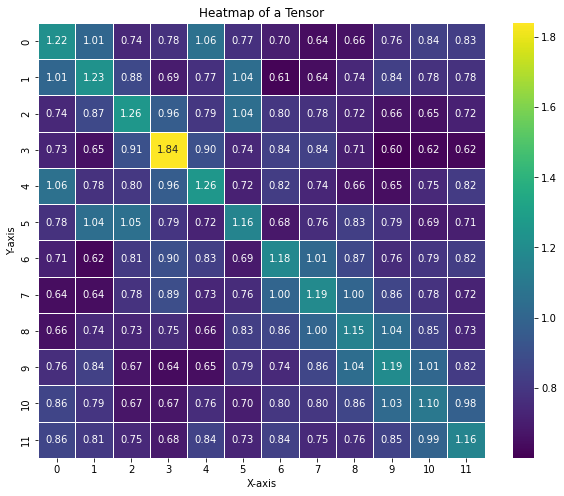

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = (ecg_embed @ ecg_embed.transpose(-2, -1)).softmax(dim=-1) * 10

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of a Tensor')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

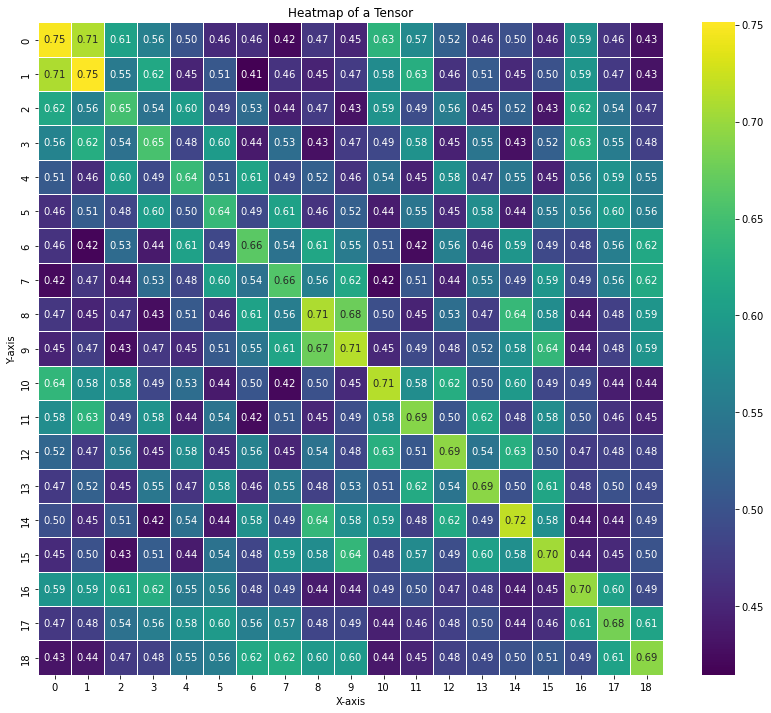

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = (eeg_embed @ eeg_embed.transpose(-2, -1)).softmax(dim=-1) * 10

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(data, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of a Tensor')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

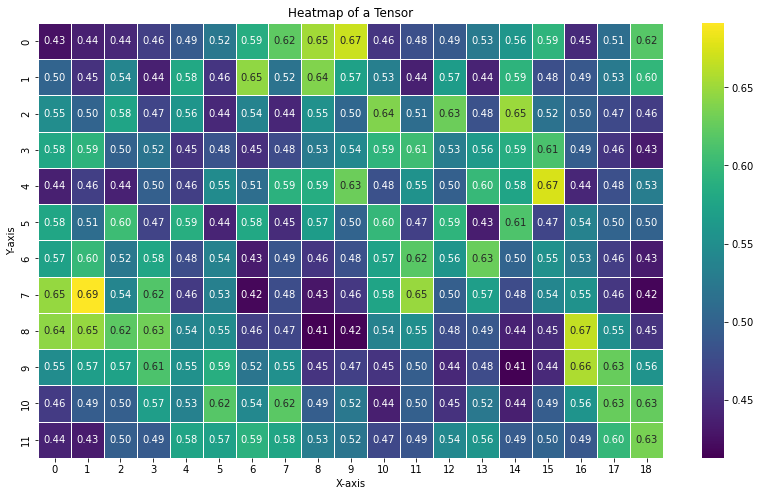

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = (ecg_embed @ eeg_embed.transpose(-2, -1)).softmax(dim=-1) * 10

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(data, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of a Tensor')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

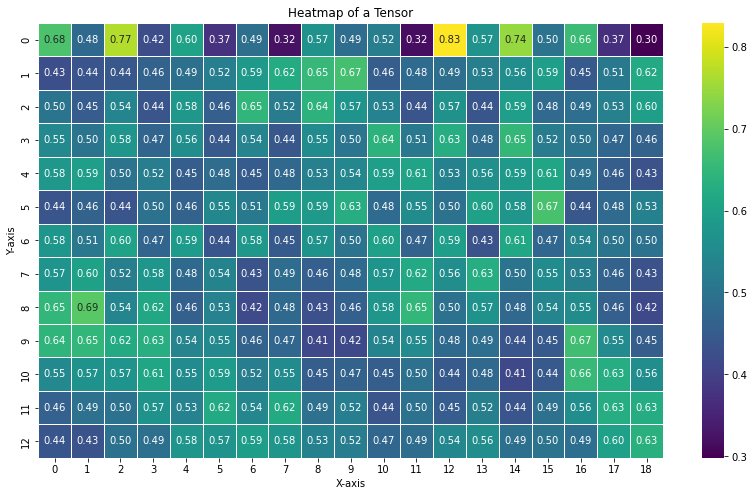

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = (ecg_embed @ eeg_embed.transpose(-2, -1)).softmax(dim=-1) * 10

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(data, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of a Tensor')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

torch.Size([12, 5000])


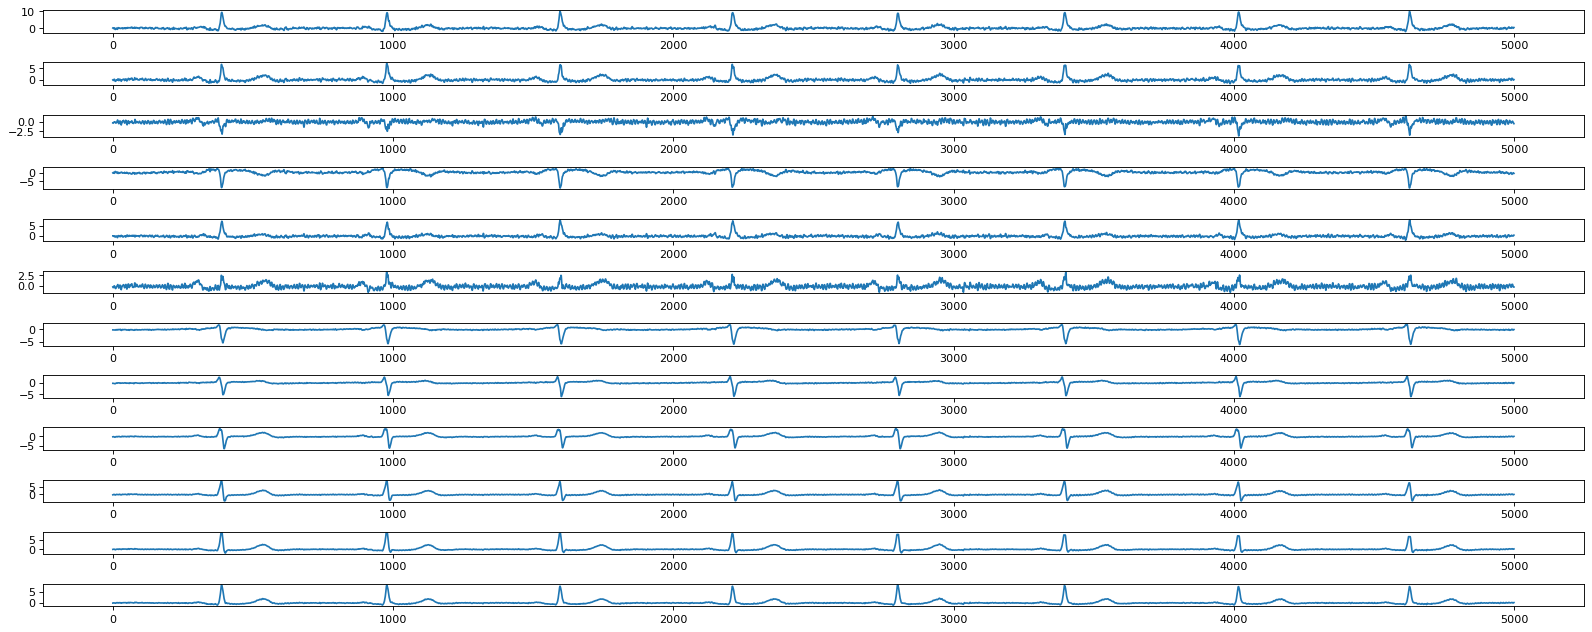

In [52]:
filtered_data = data_ecg[0]

print(filtered_data.shape)

step = 1
plt.figure(figsize=(20, 8), dpi=80)

plt.subplot(12,1,1)
plt.plot(filtered_data[0, ::step])

plt.subplot(12,1,2)
plt.plot(filtered_data[1, ::step])

plt.subplot(12,1,3)
plt.plot(filtered_data[2, ::step])

plt.subplot(12,1,4)
plt.plot(filtered_data[3, ::step])

plt.subplot(12,1,5)
plt.plot(filtered_data[4, ::step])

plt.subplot(12,1,6)
plt.plot(filtered_data[5, ::step])

plt.subplot(12,1,7)
plt.plot(filtered_data[6, ::step])

plt.subplot(12,1,8)
plt.plot(filtered_data[7, ::step])

plt.subplot(12,1,9)
plt.plot(filtered_data[8, ::step])

plt.subplot(12,1,10)
plt.plot(filtered_data[9, ::step])

plt.subplot(12,1,11)
plt.plot(filtered_data[10, ::step])

plt.subplot(12,1,12)
plt.plot(filtered_data[11, ::step])

plt.tight_layout()
plt.show()

In [27]:
ckpt["model"]["pos_embed_y.weight"]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0547, -0.0534,  0.0197,  ..., -0.0036,  0.0699, -0.0223],
        [-0.0702,  0.0012, -0.0119,  ..., -0.0502,  0.0559, -0.0673],
        ...,
        [-0.1508, -0.0117, -0.0996,  ..., -0.0991, -0.0128,  0.1275],
        [-0.1773,  0.0325, -0.0343,  ..., -0.0685, -0.0861,  0.1563],
        [-0.0991,  0.0508,  0.0618,  ..., -0.0062, -0.0756,  0.0553]])

In [29]:
my_embeds = torch.nn.Embedding.from_pretrained(ckpt["model"]["pos_embed_y.weight"])
my_embeds.weight.shape

torch.Size([32, 96])

In [2]:
ckpt = torch.load("/home/oturgut/mae/output/pre/zaggy/cos_weight0.0/ncc_weight0.1/seed0/tinyDeep2/t2500/p1x100/wd0.15/m0.8/pre_b512_blr1e-5/checkpoint-15-ncc-0.4253.pth")

In [3]:
ckpt.keys()

dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])

In [4]:
for name, params in ckpt["model"].items():
    print(name)

cls_token
mask_token
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
blocks.2.attn.qkv.bias
blocks.2.attn.proj.weight
blocks.2.attn.proj.bias
blocks.2.norm2.weight
blocks.2.norm2.bias
blocks.2.mlp.fc1.weight
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.weight
blocks.2.mlp.fc2.bias
blocks.3.norm1.weight
blocks.3.norm1.bias
blocks.3.attn.qkv.weight
blocks.3.attn.qkv.bias
blocks.3.attn.proj.we

Other

In [2]:
data_train = torch.load("/home/oturgut/data/processed/signalnet/data_train_all.pt")
data_val = torch.load("/home/oturgut/data/processed/signalnet/data_val_all.pt")

In [3]:
new_data_train = []
for data in data_train:
    if data.shape[-2] == 12:
        new_data_train.append(("ecg", data.unsqueeze(0)))
    else:
        new_data_train.append(("eeg", data.unsqueeze(0)))

In [5]:
[(data[0], data[1].shape) for data in new_data_train[:3]]

[('ecg', torch.Size([1, 12, 5000])),
 ('ecg', torch.Size([1, 12, 5000])),
 ('eeg', torch.Size([1, 19, 6000]))]

In [6]:
# torch.save(new_data_train, "/home/oturgut/data/processed/signalnet/data_train_new.pt")

In [7]:
new_data_val = []
for data in data_val:
    if data.shape[-2] == 12:
        new_data_val.append(("ecg", data.unsqueeze(0)))
    else:
        new_data_val.append(("eeg", data.unsqueeze(0)))

In [8]:
[(data[0], data[1].shape) for data in new_data_val[:3]]

[('eeg', torch.Size([1, 19, 6000])),
 ('ecg', torch.Size([1, 12, 5000])),
 ('ecg', torch.Size([1, 12, 5000]))]

In [9]:
# torch.save(new_data_val, "/home/oturgut/data/processed/signalnet/data_val_new.pt")

Combine TUH and UKBB for signal transformer

In [12]:
ukbb_data = torch.load("/home/oturgut/data/processed/ukbb/processed/ecgs_val_ecg_imaging_float32.pt")
print(ukbb_data.shape)

torch.Size([6007, 12, 5000])


In [13]:
tuh_data = torch.load("/home/oturgut/data/processed/tuh/data_val.pt")
print(tuh_data.shape)

torch.Size([1961, 19, 6000])


In [14]:
ukbb_list = [tensor for tensor in ukbb_data]

In [15]:
tuh_list = [tensor for tensor in tuh_data]

In [16]:
all_list = ukbb_list + tuh_list
len(all_list)

7968

In [17]:
random.shuffle(all_list)

In [18]:
all_list[:2]

[tensor([[ 0.3438,  1.0202,  0.9141,  ..., -0.8815, -0.8927, -0.8307],
         [ 0.0566,  0.1327,  0.0644,  ..., -0.9444, -0.9543, -0.9543],
         [ 0.8438,  2.3651,  1.9075,  ..., -1.0897, -1.1051, -0.9757],
         ...,
         [ 0.7800,  2.1892,  1.7871,  ..., -1.2616, -1.2700, -1.2291],
         [ 0.6310,  1.7814,  1.4852,  ..., -1.3117, -1.3237, -1.2635],
         [ 0.2831,  0.8367,  0.7744,  ..., -1.1488, -1.1570, -1.1006]]),
 tensor([[-0.5583, -0.8936, -0.9389,  ..., -0.3614, -0.1537, -0.1947],
         [-0.3435, -0.6743, -0.7565,  ..., -0.7393, -0.4850, -0.2721],
         [ 0.1404,  0.1476,  0.1135,  ..., -0.4049, -0.3579, -0.1038],
         ...,
         [-0.1380, -0.2149, -0.2511,  ..., -0.5651, -0.3606, -0.1562],
         [-0.2140, -0.3336, -0.3720,  ..., -0.6161, -0.4523, -0.2074],
         [-0.1797, -0.2597, -0.2990,  ..., -0.5497, -0.4263, -0.2217]])]

In [19]:
[sample.shape for sample in all_list[:5]]

[torch.Size([19, 6000]),
 torch.Size([12, 5000]),
 torch.Size([12, 5000]),
 torch.Size([19, 6000]),
 torch.Size([12, 5000])]

In [18]:
train_list = all_list[:2000]
val_list = all_list[2000:]

In [20]:
# torch.save(all_list, "/home/oturgut/data/processed/signalnet/data_train_all.pt")
# torch.save(all_list, "/home/oturgut/data/processed/signalnet/data_val_all.pt")

Other

In [2]:
tinyDeep_cos = torch.tensor([75.1, 75.517, 75.557, 75.151, 75.278])
tinyDeep_cos.mean(), tinyDeep_cos.std()

(tensor(75.3206), tensor(0.2084))

In [3]:
tinyDeep = torch.tensor([73.79, 73.99, 74.536, 74.628, 74.688])
tinyDeep.mean(), tinyDeep.std()

(tensor(74.3264), tensor(0.4082))

In [4]:
tiny = torch.tensor([74.09, 74.16, 74.68, 74.703, 74.886])
tiny.mean(), tiny.std()

(tensor(74.5038), tensor(0.3558))

Visualize the attentions of the signal encoder after pre-training

In [34]:
# Load data
ecg_data = torch.load("/home/oturgut/data/processed/ukbb/processed/ecgs_val_ecg_imaging_float32.pt")
print(ecg_data.shape)

data_sample = ecg_data[:4][:, None, :, :2500]
print(data_sample.shape)

torch.Size([6007, 12, 5000])
torch.Size([4, 1, 12, 2500])


In [2]:
# Import the Vision Transformer

from functools import partial

import torch
import torch.nn as nn

import timm
import timm.models.vision_transformer


class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, attention_pool=False, 
                 masking_blockwise=False, mask_ratio=0.0, mask_c_ratio=0.0, mask_t_ratio=0.0, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        self.masking_blockwise = masking_blockwise
        self.mask_ratio = mask_ratio
        self.mask_c_ratio = mask_c_ratio
        self.mask_t_ratio = mask_t_ratio

        if global_pool:
            self.pool = "global_pool" 
        elif attention_pool:
            self.pool = "attention_pool"
            self.attention_pool = nn.MultiheadAttention(embed_dim=kwargs['embed_dim'], 
                                                        num_heads=kwargs['num_heads'], batch_first=True)
        else:
            self.pool = False
            
        if self.pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm        
        
        for block in self.blocks:
            block.attn.forward = self._attention_forward_wrapper(block.attn)
        
    def _attention_forward_wrapper(self, attn_obj):
        """
        Modified version of def forward() of class Attention() in timm.models.vision_transformer
        """
        def my_forward(x):
            B, N, C = x.shape # C = embed_dim
            # (3, B, Heads, N, head_dim)
            qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

            # (B, Heads, N, N)
            attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
            attn = attn.softmax(dim=-1)
            attn = attn_obj.attn_drop(attn)
            # (B, Heads, N, N)
            attn_obj.attn_map = attn # this was added 

            # (B, N, Heads*head_dim)
            x = (attn @ v).transpose(1, 2).reshape(B, N, C)
            x = attn_obj.proj(x)
            x = attn_obj.proj_drop(x)
            return x
        return my_forward

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0

        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def random_masking_blockwise(self, x, mask_c_ratio, mask_t_ratio):
        """
        2D: ECG recording (N, 1, C, T) (masking c and t under mask_c_ratio and mask_t_ratio)
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        C, T = int(self.img_size[-2] / self.patch_size[-2]), int(self.img_size[-1] / self.patch_size[-1])
        
        # mask C
        x = x.reshape(N, C, T, D)
        len_keep_C = int(C * (1 - mask_c_ratio))
        noise = torch.rand(N, C, device=x.device)  # noise in [0, 1]
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_keep = ids_shuffle[:, :len_keep_C]
        index = ids_keep.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, T, D)
        x = torch.gather(x, dim=1, index=index) # N, len_keep_C(C'), T, D

        # mask T
        x = x.permute(0, 2, 1, 3) # N C' T D => N T C' D
        len_keep_T = int(T * (1 - mask_t_ratio))
        noise = torch.rand(N, T, device=x.device)  # noise in [0, 1]
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_keep = ids_shuffle[:, :len_keep_T]
        index = ids_keep.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, len_keep_C, D)
        x_masked = torch.gather(x, dim=1, index=index)
        x_masked = x_masked.permute(0, 2, 1, 3) # N T' C' D => N C' T' D 
        
        x_masked = x_masked.reshape(N, len_keep_T*len_keep_C, D) # N C' T' D => N L' D
            
        return x_masked, None, None

    def forward_features(self, x):
        """
        x: [B=N, L, D], sequence
        """
        B = x.shape[0]
        x = self.patch_embed(x)

        x = x + self.pos_embed[:, 1:, :]
        if self.masking_blockwise:
            x, _, _ = self.random_masking_blockwise(x, self.mask_c_ratio, self.mask_t_ratio)
        else:
            x, _, _ = self.random_masking(x, self.mask_ratio)

        cls_token = self.cls_token + self.pos_embed[:, 0, :]
        cls_tokens = cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.pool == "attention_pool":
            q = x[:, 1:, :].mean(dim=1, keepdim=True)
            k = x[:, 1:, :]
            v = x[:, 1:, :]
            x, x_weights = self.attention_pool(q, k, v) # attention pool without cls token
            outcome = self.fc_norm(x.squeeze(dim=1))
        elif self.pool == "global_pool":
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else: # cls token
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome

    def forward_head(self, x, pre_logits: bool = False):
        if self.global_pool:
            x = x[:, self.num_prefix_tokens:].mean(dim=1) if self.global_pool == 'avg' else x[:, :]
        x = self.fc_norm(x)
        
        return x if pre_logits else self.head(x)


def vit_tiny_patchX(**kwargs):
    model = VisionTransformer(
        embed_dim=384, depth=3, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [7]:
global_pool = True
attention_pool = False

model = vit_tiny_patchX(
    img_size=(1, 12, 2500),
    patch_size=(1, 100),
    num_classes=2,
    drop_path_rate=0.1,
    global_pool=global_pool,
    attention_pool=attention_pool,
    masking_blockwise=False,
    mask_ratio=0.0,
    mask_c_ratio=0.0,
    mask_t_ratio=0.0
)

In [3]:
# Define the pos embedding functions

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: (grid_height, grid_width)
    return:
    pos_embed: [grid_height*grid_width, embed_dim] or [1+grid_height*grid_width, embed_dim] (w/o or w/ cls_token)
    """
    grid_height, grid_width = grid_size
    grid_h = np.arange(grid_height, dtype=np.float32)
    grid_w = np.arange(grid_width, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_height, grid_width])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid width
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_w = np.arange(grid_size, dtype=np.float32)

    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid_w)

    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)

    return pos_embed
    

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


# --------------------------------------------------------
# Interpolate position embeddings for high-resolution
# References:
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------
def interpolate_pos_embed(model, checkpoint_model, checkpoint_input_size):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches

        # height, width for the checkpoint position embedding
        patch_embed_checkpoint = checkpoint_model['patch_embed.proj.weight']
        orig_patch_heigt = patch_embed_checkpoint.shape[-2]
        orig_patch_width = patch_embed_checkpoint.shape[-1]
        orig_height = int(checkpoint_input_size[-2] / orig_patch_heigt)
        orig_width = int(checkpoint_input_size[-1] / orig_patch_width)

        # height, width for the new position embedding
        new_height, _ = model.patch_embed.grid_size
        new_width = int(num_patches / new_height)

        # class_token and dist_token are kept unchanged
        if orig_width != new_width:
            print("Position interpolate from %dx%d to %dx%d" % (orig_height, orig_width, new_height, new_width))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_height, orig_width, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_height, new_width), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed

In [37]:
finetune = "/home/oturgut/mae/checkpoints/tiny/v1/checkpoint-399.pth"
finetune = "/home/oturgut/mae/checkpoints/mm_v230_mae_checkpoint.pth"

In [ ]:
# Load pre-trained model from checkpoint

from timm.models.layers import trunc_normal_

checkpoint = torch.load(finetune, map_location='cpu')

print("Load pre-trained checkpoint from: %s" % finetune)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# interpolate position embedding
checkpoint_input_size = checkpoint['args'].input_size
interpolate_pos_embed(model, checkpoint_model, checkpoint_input_size)

# load pre-trained model
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

if global_pool:
    assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}
elif attention_pool:
    pass
else:
    assert set(msg.missing_keys) == {'head.weight', 'head.bias'}

# manually initialize fc layer
trunc_normal_(model.head.weight, std=0.01)

In [39]:
with torch.no_grad():
    output = model(data_sample)

print(output.shape)

torch.Size([4, 2])


In [45]:
# Define plot function

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import numpy as np


def plot_attention(original_signal, attention_map, sample_idx, head_idx=0, filename=None):
    B, C, C_sig, T_sig = original_signal.shape
    B, Heads, N, N = attention_map.shape
    NpC = int((N-1) / C_sig)

    # Only for nice visualization 
    original_signal = (original_signal + 0.5 * abs(original_signal.min()))

    # fig, axes = plt.subplots(nrows=C_sig, sharex=True, figsize=(16, 8))
    fig, axes = plt.subplots(nrows=C_sig, figsize=(16, 8))

    for channel in range(C_sig):
        # Retrieve the attention of the channel
        # (B, Heads, N_(C_sig), N-1)
        attention_map_ch = attention_map[:, :, 1+channel*NpC:1+(channel+1)*NpC, 1:]  # Ignore the cls token

        # Average the attention of all tokens to this channel
        # (B, Heads, N_(C_sig))
        attention_map_ch = attention_map_ch.mean(dim=-1)

        # Normalize
        attention_map_ch = (attention_map_ch - attention_map_ch.min()) / (attention_map_ch.max() - attention_map_ch.min())

        # Interpolate to the original signal length
        # (B, Heads, T_sig)
        attention_map_ch = F.interpolate(attention_map_ch, size=T_sig, mode='linear')

        # Get the original signal
        # (T_sig)
        original_signal_ch = original_signal[sample_idx, 0, channel].cpu()
        # (Heads, T_sig)
        attention_map_ch = attention_map_ch[sample_idx].cpu()

        # define the axis
        t = np.arange(T_sig)
        vertices = np.column_stack([t, original_signal_ch])

        axes[channel].plot(t, original_signal_ch, color='white', linewidth=2)

        # Use LineCollection to draw varying colors
        segments = np.stack([vertices[:-1], vertices[1:]], axis=1)
        lc = LineCollection(segments, cmap='YlGnBu', norm=plt.Normalize(attention_map_ch[head_idx].min(), attention_map_ch[head_idx].max()), linewidth=1)
        lc.set_array(attention_map_ch[head_idx])
        axes[channel].add_collection(lc)

        axes[channel].set_ylim(original_signal_ch.min(), original_signal_ch.max())
        # axes[channel].set_title(f'Channel {channel + 1}')
        if channel < C_sig-1: axes[channel].set_xticks([])

        axes[channel].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    # Add color bar at the very right
    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(lc, cax=cbar_ax)
    cbar.set_label('Attention Weights')

    # Remove y labels of all subplots
    [ax.yaxis.set_visible(False) for ax in axes.ravel()]

    plt.tight_layout()
    if filename:
        plt.savefig(f"/home/oturgut/mae/figures/{filename}_head{head_idx}.png", bbox_inches='tight', transparent=True, dpi=250)

    plt.show()

In [40]:
attention_map = model.blocks[1].attn.attn_map
print(attention_map.shape)

torch.Size([4, 6, 301, 301])


/tmp/ipykernel_1486803/2367614670.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


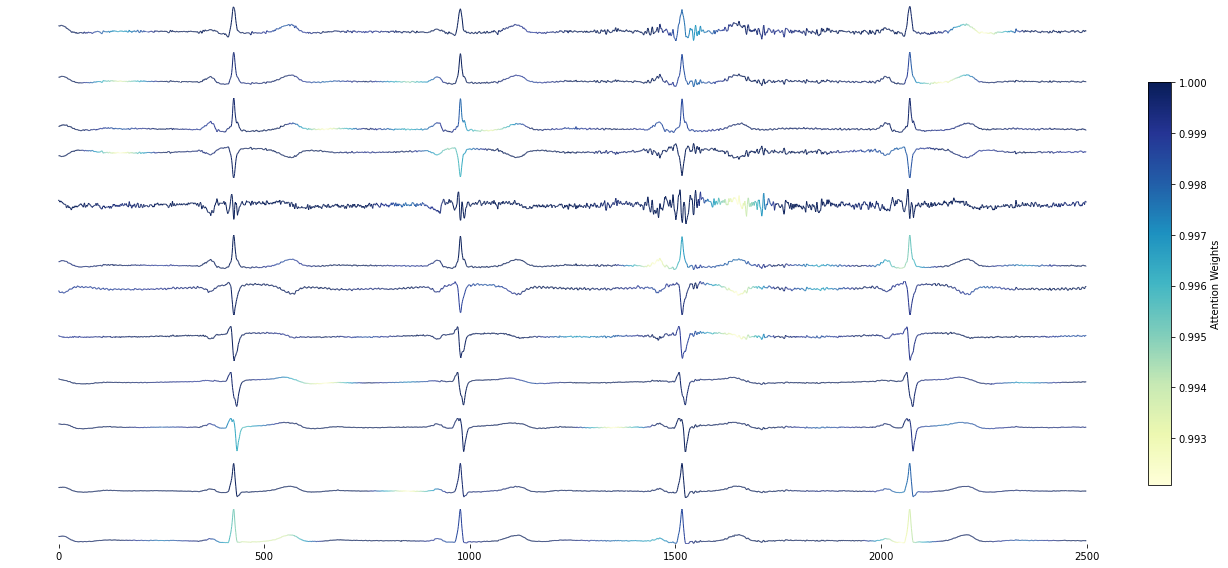

In [46]:
plot_attention(data_sample, attention_map, sample_idx=1, head_idx=0)

Bar plots showing the performance on the age regression task using different checkpoints

In [2]:
data_path = "/home/oturgut/data/processed/lemon/kfold/fold1"

trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
pred = torch.load("/home/oturgut/mae/output/fin/lemon/kfold/fold1/eeg/Age/ukbb_pretrained/seed0/tiny/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-5_b128_blr1e-5/logits/logits_68.pt")

print(pred.shape)
print(trgt.shape)

torch.Size([38, 1])
torch.Size([38, 1])


In [3]:
pcc = np.concatenate([r_regression(pred[:, i].view(-1, 1), trgt[:, i]) for i in range(trgt.shape[-1])], axis=0)
print(pcc)
r2 = r2_score(trgt, pred)
print(r2)
print(trgt_raw.std() * mean_absolute_error(trgt, pred))

[0.87581429]
0.7410373395097682
tensor(5.8301)


In [3]:
r2_SiT = []
mae_SiT = []

logits_ckpt = [176, 64, 114, 68, 82, 77, 111, 137, 82, 96] # blr 3e-5
# logits_ckpt = [94, 73, 130, 41, 140, 68, 154, 47, 65, 90] # blr 1e-4
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/SiT/output/fin/lemon/kfold_server/fold{fold}/eeg/Age/SiT/seed0/tinyDeep/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr3e-5/logits/logits_{logits_ckpt[fold]}.pt")
    # pred = torch.load(f"/home/oturgut/SiT/output/fin/lemon/kfold_server/fold{fold}/eeg/Age/SiT/seed0/tinyDeep/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-4/logits/logits_{logits_ckpt[fold]}.pt")

    r2_SiT.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_SiT.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_SiT: {torch.tensor(r2_SiT)}")
print(torch.tensor(r2_SiT).mean(), torch.tensor(r2_SiT).std())

print(f"\nMAE_SiT: {torch.tensor(mae_SiT)}")
print(torch.tensor(mae_SiT).mean(), torch.tensor(mae_SiT).std())

R2_SiT: tensor([0.7106, 0.7944, 0.7078, 0.3379, 0.5385, 0.4917, 0.8961, 0.7523, 0.5401,
        0.5907], dtype=torch.float64)
tensor(0.6360, dtype=torch.float64) tensor(0.1658, dtype=torch.float64)

MAE_SiT: tensor([ 6.8035,  6.2727,  6.9656, 10.2192,  9.2560,  8.1576,  4.2976,  7.6209,
         8.3909,  9.9554])
tensor(7.7939) tensor(1.8079)


In [4]:
r2_SiT = []
mae_SiT = []

# logits_ckpt = [176, 64, 114, 68, 82, 77, 111, 137, 82, 96] # blr 3e-5
logits_ckpt = [94, 73, 130, 41, 140, 68, 154, 47, 65, 90] # blr 1e-4
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    # pred = torch.load(f"/home/oturgut/SiT/output/fin/lemon/kfold_server/fold{fold}/eeg/Age/SiT/seed0/tinyDeep/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr3e-5/logits/logits_{logits_ckpt[fold]}.pt")
    pred = torch.load(f"/home/oturgut/SiT/output/fin/lemon/kfold_server/fold{fold}/eeg/Age/SiT/seed0/tinyDeep/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-4/logits/logits_{logits_ckpt[fold]}.pt")

    r2_SiT.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_SiT.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_SiT: {torch.tensor(r2_SiT)}")
print(torch.tensor(r2_SiT).mean(), torch.tensor(r2_SiT).std())

print(f"\nMAE_SiT: {torch.tensor(mae_SiT)}")
print(torch.tensor(mae_SiT).mean(), torch.tensor(mae_SiT).std())

R2_SiT: tensor([0.7010, 0.8118, 0.7847, 0.4258, 0.6204, 0.5155, 0.8856, 0.6314, 0.6195,
        0.5997], dtype=torch.float64)
tensor(0.6595, dtype=torch.float64) tensor(0.1393, dtype=torch.float64)

MAE_SiT: tensor([6.7114, 5.9088, 6.2805, 9.2437, 8.2023, 7.4483, 4.0309, 8.5731, 7.4398,
        8.8878])
tensor(7.2727) tensor(1.5908)


In [2]:
r2_SiT = []
mae_SiT = []

logits_ckpt = [115, 82, 125, 95, 120, 5, 77, 60, 85, 71]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/SiT/output/fin/lemon/kfold/fold{fold}/SiT/seed0/tinyDeep/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr3e-5_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_SiT.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_SiT.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_SiT: {torch.tensor(r2_SiT)}")
print(torch.tensor(r2_SiT).mean(), torch.tensor(r2_SiT).std())

print(f"\nMAE_SiT: {torch.tensor(mae_SiT)}")
print(torch.tensor(mae_SiT).mean(), torch.tensor(mae_SiT).std())

R2_SiT: tensor([0.7481, 0.8035, 0.8356, 0.2579, 0.8834, 0.3700, 0.8357, 0.8610, 0.5971,
        0.7151], dtype=torch.float64)
tensor(0.6907, dtype=torch.float64) tensor(0.2170, dtype=torch.float64)

MAE_SiT: tensor([ 5.8355,  4.9794,  5.5323,  9.6379,  5.1335, 11.6158,  5.0221,  6.0722,
         7.3560,  8.0108])
tensor(6.9195) tensor(2.2410)


In [5]:
r2_mimicSmall = []
mae_mimicSmall = []

logits_ckpt = [135, 96, 52, 86, 157, 46, 149, 102, 121, 93]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/mae/output/fin/lemon/kfold/fold{fold}/eeg/Age/mimic_pretrained/seed0/smallDeep/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b16_blr1e-4_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_mimicSmall.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_mimicSmall.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_mimicSmall: {torch.tensor(r2_mimicSmall)}")
print(torch.tensor(r2_mimicSmall).mean(), torch.tensor(r2_mimicSmall).std())

print(f"\nMAE_mimcSmall: {torch.tensor(mae_mimicSmall)}")
print(torch.tensor(mae_mimicSmall).mean(), torch.tensor(mae_mimicSmall).std())

R2_mimicSmall: tensor([0.7900, 0.8595, 0.7136, 0.4517, 0.9715, 0.5868, 0.9396, 0.9468, 0.6242,
        0.7995], dtype=torch.float64)
tensor(0.7683, dtype=torch.float64) tensor(0.1729, dtype=torch.float64)

MAE_mimcSmall: tensor([ 5.1394,  5.5820,  7.4576, 10.3246,  2.8184,  8.8058,  3.6462,  3.7396,
         6.9603,  7.2733])
tensor(6.1747) tensor(2.4181)


In [6]:
r2_ukbb10k = []
mae_ukbb10k = []

logits_ckpt = [105, 98, 152, 72, 159, 42, 56, 95, 58, 22]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/mae/output/fin/lemon/kfold/fold{fold}/eeg/Age/ukbb_10k_pretrained/seed0/tiny/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-5_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_ukbb10k.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_ukbb10k.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_ukbb10k: {torch.tensor(r2_ukbb10k)}")
print(torch.tensor(r2_ukbb10k).mean(), torch.tensor(r2_ukbb10k).std())

print(f"\nMAE_ukbb10k: {torch.tensor(mae_ukbb10k)}")
print(torch.tensor(mae_ukbb10k).mean(), torch.tensor(mae_ukbb10k).std())

R2_ukbb10k: tensor([0.6687, 0.7702, 0.6868, 0.3891, 0.6871, 0.4422, 0.7380, 0.7990, 0.5644,
        0.6514], dtype=torch.float64)
tensor(0.6397, dtype=torch.float64) tensor(0.1354, dtype=torch.float64)

MAE_ukbb10k: tensor([ 7.3223,  5.6807,  7.5118, 10.2901,  6.7327,  9.6741,  6.1017,  7.2169,
         8.6971, 10.4669])
tensor(7.9694) tensor(1.7162)


In [7]:
r2_ukbbAll = []
mae_ukbbAll = []

logits_ckpt = [82, 51, 166, 123, 94, 108, 53, 38, 161, 91]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/mae/output/fin/lemon/kfold/fold{fold}/eeg/Age/ukbb_all_pretrained/seed0/tiny/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-5_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_ukbbAll.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_ukbbAll.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_ukbbAll: {torch.tensor(r2_ukbbAll)}")
print(torch.tensor(r2_ukbbAll).mean(), torch.tensor(r2_ukbbAll).std())

print(f"\nMAE_ukbbAll: {torch.tensor(mae_ukbbAll)}")
print(torch.tensor(mae_ukbbAll).mean(), torch.tensor(mae_ukbbAll).std())

R2_ukbbAll: tensor([0.6976, 0.6998, 0.6580, 0.5058, 0.9153, 0.4779, 0.7567, 0.8321, 0.6441,
        0.7575], dtype=torch.float64)
tensor(0.6945, dtype=torch.float64) tensor(0.1341, dtype=torch.float64)

MAE_ukbbAll: tensor([7.4622, 6.6134, 7.9386, 9.3198, 3.7830, 8.2913, 5.9189, 7.2050, 6.8214,
        8.3132])
tensor(7.1667) tensor(1.5395)


In [8]:
r2_tuh250Hz = []
mae_tuh250Hz = []

logits_ckpt = [119, 37, 105, 72, 146, 42, 146, 164, 130, 142]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/mae/output/fin/lemon/kfold/fold{fold}/eeg/Age/tuh250Hz_pretrained/seed0/tiny/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-5_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_tuh250Hz.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_tuh250Hz.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_tuh250Hz: {torch.tensor(r2_tuh250Hz)}")
print(torch.tensor(r2_tuh250Hz).mean(), torch.tensor(r2_tuh250Hz).std())

print(f"\nMAE_tuh250Hz: {torch.tensor(mae_tuh250Hz)}")
print(torch.tensor(mae_tuh250Hz).mean(), torch.tensor(mae_tuh250Hz).std())

R2_tuh250Hz: tensor([0.6523, 0.6452, 0.7115, 0.3767, 0.6072, 0.5088, 0.7762, 0.7738, 0.5836,
        0.6383], dtype=torch.float64)
tensor(0.6274, dtype=torch.float64) tensor(0.1206, dtype=torch.float64)

MAE_tuh250Hz: tensor([ 7.8264,  9.0570,  7.8570, 11.0275,  8.6965, 10.1680,  6.0024,  7.1408,
         8.3794,  8.7740])
tensor(8.4929) tensor(1.4361)


In [9]:
r2_tuh = []
mae_tuh = []

logits_ckpt = [153, 87, 148, 167, 170, 5, 96, 152, 131, 39]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/mae/output/fin/lemon/kfold/fold{fold}/eeg/Age/tuh_pretrained/seed0/tiny/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-5_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_tuh.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_tuh.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_tuh: {torch.tensor(r2_tuh)}")
print(torch.tensor(r2_tuh).mean(), torch.tensor(r2_tuh).std())

print(f"\nMAE_tuh: {torch.tensor(mae_tuh)}")
print(torch.tensor(mae_tuh).mean(), torch.tensor(mae_tuh).std())

R2_tuh: tensor([0.5639, 0.7241, 0.7481, 0.4470, 0.6761, 0.3697, 0.6872, 0.7388, 0.5606,
        0.5813], dtype=torch.float64)
tensor(0.6097, dtype=torch.float64) tensor(0.1285, dtype=torch.float64)

MAE_tuh: tensor([ 8.8333,  7.1724,  7.1635,  9.8652,  6.7838, 13.7223,  7.3482,  7.4691,
         9.1425, 11.4908])
tensor(8.8991) tensor(2.2582)


In [10]:
r2_scratch = []
mae_scratch = []

logits_ckpt = [102, 85, 136, 39, 166, 47, 166, 177, 143, 60]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/mae/output/fin/lemon/kfold/fold{fold}/eeg/Age/Scratch/seed0/tiny/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-4_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_scratch.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_scratch.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_scratch: {torch.tensor(r2_scratch)}")
print(torch.tensor(r2_scratch).mean(), torch.tensor(r2_scratch).std())

print(f"\nMAE_scratch: {torch.tensor(mae_scratch)}")
print(torch.tensor(mae_scratch).mean(), torch.tensor(mae_scratch).std())

R2_scratch: tensor([0.5370, 0.8412, 0.6262, 0.1015, 0.6195, 0.4025, 0.7843, 0.8117, 0.6138,
        0.6035], dtype=torch.float64)
tensor(0.5941, dtype=torch.float64) tensor(0.2184, dtype=torch.float64)

MAE_scratch: tensor([10.1852,  5.5592,  8.4822, 12.5982,  8.4927, 12.3926,  5.2558,  6.5473,
         8.9798, 10.4138])
tensor(8.8907) tensor(2.5850)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

axs[0].set_title('R2 [10-fold cross validation]')
axs[0].boxplot(torch.tensor(r2_scratch))
axs[0].scatter(torch.ones(len(r2_scratch)), torch.tensor(r2_scratch), alpha=0.25)
axs[0].set_xticklabels(["LEMON"])

axs[1].set_title('MAE [10-fold cross validation]')
axs[1].boxplot(torch.tensor(mae_scratch))
axs[1].scatter(torch.ones(len(mae_scratch)), torch.tensor(mae_scratch), alpha=0.25)
axs[1].set_xticklabels(["LEMON"])

plt.show()

In [11]:
r2_mm = []
mae_mm = []

logits_ckpt = [81, 85, 126, 83, 100, 36, 154, 98, 88, 56]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/mae/output/fin/lemon/kfold/fold{fold}/eeg/Age/mm_ukbb_pretrained/seed0/tiny/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-5_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_mm.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_mm.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_mm: {torch.tensor(r2_mm)}")
print(torch.tensor(r2_mm).mean(), torch.tensor(r2_mm).std())

print(f"\nMAE_mm: {torch.tensor(mae_mm)}")
print(torch.tensor(mae_mm).mean(), torch.tensor(mae_mm).std())

R2_mm: tensor([0.7828, 0.7476, 0.6678, 0.5674, 0.9378, 0.5515, 0.8148, 0.8363, 0.6028,
        0.8324], dtype=torch.float64)
tensor(0.7341, dtype=torch.float64) tensor(0.1306, dtype=torch.float64)

MAE_mm: tensor([6.2411, 6.5868, 8.0440, 8.5259, 3.7527, 9.4247, 5.2804, 5.9725, 7.0377,
        6.5904])
tensor(6.7456) tensor(1.6372)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

axs[0].set_title('R2 [10-fold cross validation]')
axs[0].boxplot(torch.tensor(r2_mm))
axs[0].scatter(torch.ones(len(r2_mm)), torch.tensor(r2_mm), alpha=0.25)
axs[0].set_xticklabels(["LEMON"])

axs[1].set_title('MAE [10-fold cross validation]')
axs[1].boxplot(torch.tensor(mae_mm))
axs[1].scatter(torch.ones(len(mae_mm)), torch.tensor(mae_mm), alpha=0.25)
axs[1].set_xticklabels(["LEMON"])

plt.show()

In [12]:
r2_um = []
mae_um = []

logits_ckpt = [171, 68, 149, 123, 100, 108, 123, 81, 109, 51]
for fold in range(10):
    data_path = f"/home/oturgut/data/processed/lemon/kfold/fold{fold}"

    trgt_raw = torch.load(os.path.join(data_path, "labels_raw_val.pt"))
    trgt_raw_train = torch.load(os.path.join(data_path, "labels_raw_train.pt"))

    trgt = torch.load(os.path.join(data_path, "labels_val_stdNormed.pt"))
    pred = torch.load(f"/home/oturgut/mae/output/fin/lemon/kfold/fold{fold}/eeg/Age/ukbb_pretrained/seed0/tiny/t6000/p1x100/ld0.5/dp0.1/smth0.1/wd0.1/m0.8/fin_b32_blr1e-5_b128_blr1e-5/logits/logits_{logits_ckpt[fold]}.pt")

    r2_um.append(r2_score(trgt.squeeze(), pred.squeeze()))
    mae_um.append(trgt_raw.std() * mean_absolute_error(trgt, pred))

print(f"R2_um: {torch.tensor(r2_um)}")
print(torch.tensor(r2_um).mean(), torch.tensor(r2_um).std())

print(f"\nMAE_um: {torch.tensor(mae_um)}")
print(torch.tensor(mae_um).mean(), torch.tensor(mae_um).std())

R2_um: tensor([0.7009, 0.7410, 0.7355, 0.4631, 0.9339, 0.5939, 0.7947, 0.7784, 0.6142,
        0.7333], dtype=torch.float64)
tensor(0.7089, dtype=torch.float64) tensor(0.1282, dtype=torch.float64)

MAE_um: tensor([6.9435, 5.8301, 7.6254, 8.5887, 3.6181, 7.5424, 5.3569, 6.5457, 6.9045,
        9.7299])
tensor(6.8685) tensor(1.7066)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

axs[0].set_title('R2 [10-fold cross validation]')
axs[0].boxplot(torch.tensor(r2_um))
axs[0].scatter(torch.ones(len(r2_um)), torch.tensor(r2_um), alpha=0.25)
axs[0].set_xticklabels(["LEMON"])

axs[1].set_title('MAE [10-fold cross validation]')
axs[1].boxplot(torch.tensor(mae_um))
axs[1].scatter(torch.ones(len(mae_um)), torch.tensor(mae_um), alpha=0.25)
axs[1].set_xticklabels(["LEMON"])

plt.show()

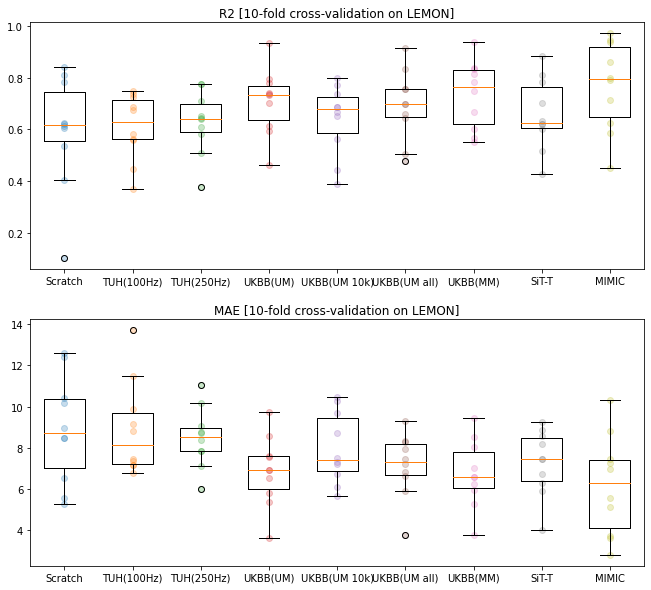

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(11, 10))

# Shared column names
column_names = ["Scratch", "TUH(100Hz)", "TUH(250Hz)", "UKBB(UM)", "UKBB(UM 10k)", "UKBB(UM all)", "UKBB(MM)", "SiT-T", "MIMIC"]

# R2 plots
axs[0].boxplot([torch.tensor(r2_scratch), torch.tensor(r2_tuh), torch.tensor(r2_tuh250Hz), torch.tensor(r2_um), torch.tensor(r2_ukbb10k), torch.tensor(r2_ukbbAll), torch.tensor(r2_mm), torch.tensor(r2_SiT), torch.tensor(r2_mimicSmall)], labels=column_names, widths=0.6)
axs[0].scatter(torch.ones(len(r2_scratch)), torch.tensor(r2_scratch), alpha=0.25)
axs[0].scatter(torch.ones(len(r2_tuh)) * 2, torch.tensor(r2_tuh), alpha=0.25)
axs[0].scatter(torch.ones(len(r2_tuh250Hz)) * 3, torch.tensor(r2_tuh250Hz), alpha=0.25)
axs[0].scatter(torch.ones(len(r2_um)) * 4, torch.tensor(r2_um), alpha=0.25)
axs[0].scatter(torch.ones(len(r2_ukbb10k)) * 5, torch.tensor(r2_ukbb10k), alpha=0.25)
axs[0].scatter(torch.ones(len(r2_ukbbAll)) * 6, torch.tensor(r2_ukbbAll), alpha=0.25)
axs[0].scatter(torch.ones(len(r2_mm)) * 7, torch.tensor(r2_mm), alpha=0.25)
axs[0].scatter(torch.ones(len(r2_SiT)) * 8, torch.tensor(r2_SiT), alpha=0.25)
axs[0].scatter(torch.ones(len(r2_mimicSmall)) * 9, torch.tensor(r2_mimicSmall), alpha=0.25)
axs[0].set_title('R2 [10-fold cross-validation on LEMON]')

# MAE plots
axs[1].boxplot([torch.tensor(mae_scratch), torch.tensor(mae_tuh), torch.tensor(mae_tuh250Hz), torch.tensor(mae_um), torch.tensor(mae_ukbb10k), torch.tensor(mae_ukbbAll), torch.tensor(mae_mm), torch.tensor(mae_SiT), torch.tensor(mae_mimicSmall)], labels=column_names, widths=0.6)
axs[1].scatter(torch.ones(len(mae_scratch)), torch.tensor(mae_scratch), alpha=0.25)
axs[1].scatter(torch.ones(len(mae_tuh)) * 2, torch.tensor(mae_tuh), alpha=0.25)
axs[1].scatter(torch.ones(len(mae_tuh250Hz)) * 3, torch.tensor(mae_tuh250Hz), alpha=0.25)
axs[1].scatter(torch.ones(len(mae_um)) * 4, torch.tensor(mae_um), alpha=0.25)
axs[1].scatter(torch.ones(len(mae_ukbb10k)) * 5, torch.tensor(mae_ukbb10k), alpha=0.25)
axs[1].scatter(torch.ones(len(mae_ukbbAll)) * 6, torch.tensor(mae_ukbbAll), alpha=0.25)
axs[1].scatter(torch.ones(len(mae_mm)) * 7, torch.tensor(mae_mm), alpha=0.25)
axs[1].scatter(torch.ones(len(mae_SiT)) * 8, torch.tensor(mae_SiT), alpha=0.25)
axs[1].scatter(torch.ones(len(mae_mimicSmall)) * 9, torch.tensor(mae_mimicSmall), alpha=0.25)
axs[1].set_title('MAE [10-fold cross-validation on LEMON]')

plt.show()

Scatter plots showing the results of the regression tasks

In [18]:
group1 = ['Age']
groups = {1:group1}

# Age
lower_bnd="0"
upper_bnd="1"
nb_classes="1"

pred_raw = pred * trgt_raw_train[:, int(lower_bnd):int(upper_bnd)].std(axis=0, keepdim=True) + trgt_raw_train[:, int(lower_bnd):int(upper_bnd)].mean(axis=0, keepdim=True)

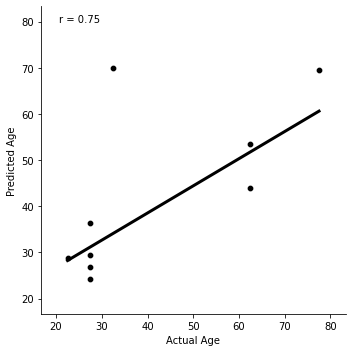

In [19]:
group = 1

# plt.rcParams.update({'font.size': 15})

for feature in range(0, int(nb_classes)):
    y = trgt_raw[:, feature+int(lower_bnd)]  # target[:, lower_bnd:upper_bnd][:, feature]
    y_hat = pred_raw[:, feature]             # prediction[:, feature]

    fig, ax = plt.subplots(figsize=(5, 5))

    ax.scatter(y[::5], y_hat[::5], c="black", edgecolors="white", lw=0.25)
    ax.plot(np.unique(y), np.poly1d(np.polyfit(y, y_hat, 1))(np.unique(y)), c="black", lw=3)

    pcc = r_regression(y_hat[:].view(-1, 1), y[:])

    ax.text(0.06, 0.975, f"r = {round(pcc.item(), 2)}", ha='left', va='top', transform=ax.transAxes)
    # number, exponent = sci_notation(scipy.stats.linregress(x, y)[3], sig_fig=2)
    # if int(exponent) == 0:
    #     ax.text(0.06, 0.9, "P = {}".format(number), ha='left', va='top', transform=ax.transAxes)
    # else:
    #     ax.text(0.06, 0.9, "P = {:.3g}".format(scipy.stats.linregress(x, y)[3]), ha='left', va='top', transform=ax.transAxes)

    # if int(exponent) == 0:
    #     ax.text(0.06, 0.9, "P = {}".format(number), ha='left', va='top', transform=ax.transAxes)
    # else:
    #     ax.text(0.06, 0.9, "P = {} x 10{}".format(number, get_super(exponent)), ha='left', va='top', transform=ax.transAxes)

    feature_name = groups[group][feature]
    ax.set_xlabel(f"Actual {feature_name}")
    ax.set_ylabel(f"Predicted {feature_name}")

    if abs(y.min()) > abs(y.max()):
        delta = abs(y.min())
    else:
        delta = abs(y.max())

    ax.set_xlim(y.min()-delta*0.075, y.max()+delta*0.075)
    ax.set_ylim(y.min()-delta*0.075, y.max()+delta*0.075)

    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)

    file_name = feature_name.split(" ")[0]

    plt.tight_layout()
    plt.savefig(f"/home/oturgut/mae/figures/lemon/tuh_pretrained_15ch_test.png")

    plt.show()

### Some illustrations

In [2]:
vit_cad_full = np.array([67.61286163330078, 67.10980987548828, 66.81634521484375, 66.51681518554688, 66.4584732055664])
mae_cad_full = np.array([72.27989196777344, 71.72045135498047, 71.67757415771484, 71.54796600341797, 71.31048583984375])
mmcl_cad_full = np.array([70.83175659179688, 70.71100616455078, 70.48370361328125, 70.21300506591797, 69.55508422851562])
ours_cad_full = np.array([73.27252960205078, 73.22577667236328, 72.99860382080078, 72.95687103271484, 72.52001190185547])

vit_af_full = np.array([72.53311920166016, 70.84889221191406, 70.17113494873047, 67.65641784667969, 67.5951156616211])
mae_af_full = np.array([73.12940979003906, 72.73545837402344, 72.21536254882812, 72.18476867675781, 71.256103515625])
mmcl_af_full = np.array([72.98047637939453, 72.71192169189453, 72.6627197265625, 71.88883209228516, 71.8210678100586])
ours_af_full = np.array([74.75678253173828, 74.37467193603516, 74.28477478027344, 73.5942611694336, 73.54499816894531])

vit_dm_full = np.array([68.2758560180664, 67.64854431152344, 67.41978454589844, 67.19747161865234, 66.20346069335938])
mae_dm_full = np.array([73.47023010253906, 73.44013214111328, 73.33379364013672, 72.93709564208984, 72.5706787109375])
mmcl_dm_full = np.array([74.07022094726562, 73.24657440185547, 73.04307556152344, 72.93145751953125, 72.75108337402344])
ours_dm_full = np.array([76.035, 75.947, 75.635, 75.581, 75.557])

In [3]:
vit_cad_tenth = np.array([58.89375305175781, 58.05362319946289, 57.45647048950195, 54.73219299316406, 53.51708984375])
mae_cad_tenth = np.array([67.79061889648438, 67.52174377441406, 67.23928833007812, 66.98030090332031, 66.87850952148438])
mmcl_cad_tenth = np.array([67.86298370361328, 67.45917510986328, 66.9808120727539, 66.4962387084961, 66.47733306884766])
ours_cad_tenth = np.array([69.6229248046875, 69.4638900756836, 69.31442260742188, 69.29564666748047, 68.29712677001953])

vit_af_tenth = np.array([55.525428771972656, 55.03451156616211, 52.72816848754883, 52.23798751831055])
mae_af_tenth = np.array([68.14936828613281, 67.4582748413086, 66.65188598632812, 66.58435821533203, 65.94855499267578])
mmcl_af_tenth = np.array([72.0012435913086, 71.19392395019531, 70.65216064453125, 70.39063262939453, 70.3685531616211])
ours_af_tenth = np.array([73.99606323242188, 73.93135070800781, 73.2955551147461, 73.25345611572266, 72.47051239013672])

vit_dm_tenth = np.array([64.08901977539062, 56.210636138916016, 56.02748489379883, 55.34673309326172, 55.0366096496582])
mae_dm_tenth = np.array([70.7940673828125, 69.96785736083984, 69.64389038085938, 69.34442138671875, 69.19990539550781])
mmcl_dm_tenth = np.array([72.5140380859375, 71.70332336425781, 71.05004119873047, 70.98115539550781, 70.30718231201172])
ours_dm_tenth = np.array([73.70523071289062, 73.4935073852539, 73.32225036621094, 73.13011169433594, 72.92003631591797])

In [4]:
vit_cad_hundredth = np.array([53.49923324584961, 53.19325256347656, 52.20558547973633, 52.10694122314453, 50.37131881713867])
mae_cad_hundredth = np.array([57.585479736328125, 56.87453079223633, 55.6873779296875, 54.62429428100586, 54.11389923095703])
mmcl_cad_hundredth = np.array([58.46168899536133, 57.95009231567383, 57.79488754272461, 56.41486740112305, 56.1640625])
ours_cad_hundredth = np.array([58.881343841552734, 56.97001266479492, 56.37723922729492, 54.087806701660156, 53.36132049560547])

vit_af_hundredth = np.array([52.46975326538086, 52.22600173950195, 51.69095230102539, 47.41161346435547, 45.157833099365234])
mae_af_hundredth = np.array([55.35368347167969, 52.74736404418945, 52.520179748535156, 52.30205535888672, 50.9490852355957])
mmcl_af_hundredth = np.array([50.46226501464844, 50.16750717163086, 48.4536018371582, 47.396751403808594, 46.48021697998047])
ours_af_hundredth = np.array([61.75330352783203, 60.8999137878418, 57.62339401245117, 57.24507141113281, 56.92536926269531])

vit_dm_hundredth = np.array([53.3189582824707, 51.192237854003906, 50.58603286743164, 50.37782287597656, 49.68620300292969])
mae_dm_hundredth = np.array([63.10688781738281, 61.08119583129883, 57.39017868041992, 56.05181884765625, 53.951133728027344])
mmcl_dm_hundredth = np.array([67.70032501220703, 61.65314865112305, 55.735408782958984, 54.7322883605957])
ours_dm_hundredth = np.array([68.40988159179688, 67.6468276977539, 63.452796936035156, 61.656044006347656])

In [5]:
x_cad = np.array([40, 400, 4000])
x_af = np.array([17, 170, 1700])
x_dm = np.array([25, 250, 2500])

In [6]:
np.array([vit_cad_tenth.mean(), vit_cad_hundredth.mean(), vit_cad_full.mean()])

array([56.53062592, 52.27526627, 66.90286102])

In [7]:
ci_vit_cad = 1.96 * np.array([vit_cad_hundredth.std(), vit_cad_tenth.std(), vit_cad_full.std()]) / np.sqrt(5)
ci_mmcl_cad = 1.96 * np.array([mmcl_cad_hundredth.std(), mmcl_cad_tenth.std(), mmcl_cad_full.std()]) / np.sqrt(5)
ci_mae_cad = 1.96 * np.array([mae_cad_hundredth.std(), mae_cad_tenth.std(), mae_cad_full.std()]) / np.sqrt(5)
ci_ours_cad = 1.96 * np.array([ours_cad_hundredth.std(), ours_cad_tenth.std(), ours_cad_full.std()]) / np.sqrt(5)

In [8]:
ci_vit_af = 1.96 * np.array([vit_af_hundredth.std(), vit_af_tenth.std(), vit_af_full.std()]) / np.sqrt(5)
ci_mmcl_af = 1.96 * np.array([mmcl_af_hundredth.std(), mmcl_af_tenth.std(), mmcl_af_full.std()]) / np.sqrt(5)
ci_mae_af = 1.96 * np.array([mae_af_hundredth.std(), mae_af_tenth.std(), mae_af_full.std()]) / np.sqrt(5)
ci_ours_af = 1.96 * np.array([ours_af_hundredth.std(), ours_af_tenth.std(), ours_af_full.std()]) / np.sqrt(5)

In [9]:
ci_vit_dm = 1.96 * np.array([vit_dm_hundredth.std(), vit_dm_tenth.std(), vit_dm_full.std()]) / np.sqrt(5)
ci_mmcl_dm = 1.96 * np.array([mmcl_dm_hundredth.std(), mmcl_dm_tenth.std(), mmcl_dm_full.std()]) / np.sqrt(5)
ci_mae_dm = 1.96 * np.array([mae_dm_hundredth.std(), mae_dm_tenth.std(), mae_dm_full.std()]) / np.sqrt(5)
ci_ours_dm = 1.96 * np.array([ours_dm_hundredth.std(), ours_dm_tenth.std(), ours_dm_full.std()]) / np.sqrt(5)

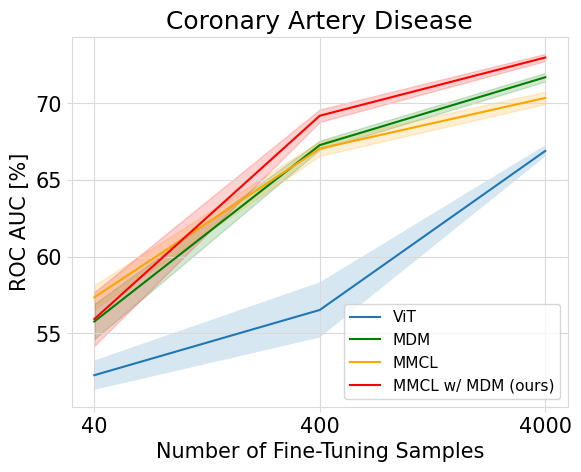

In [10]:
# plt.rcParams.update({'font.size': 15})

x = np.arange(3)
y_vit_cad = np.array([vit_cad_hundredth.mean(), vit_cad_tenth.mean(), vit_cad_full.mean()])
y_mmcl_cad = np.array([mmcl_cad_hundredth.mean(), mmcl_cad_tenth.mean(), mmcl_cad_full.mean()])
y_mae_cad = np.array([mae_cad_hundredth.mean(), mae_cad_tenth.mean(), mae_cad_full.mean()])
y_ours_cad = np.array([ours_cad_hundredth.mean(), ours_cad_tenth.mean(), ours_cad_full.mean()])

fig, ax = plt.subplots()

ax.plot(x, y_vit_cad, label='ViT')
ax.fill_between(x, (y_vit_cad-ci_vit_cad), (y_vit_cad+ci_vit_cad), alpha=.175)

ax.plot(x, y_mae_cad, 'green', label='MDM')
ax.fill_between(x, (y_mae_cad-ci_mae_cad), (y_mae_cad+ci_mae_cad), color='green', alpha=.175)

ax.plot(x, y_mmcl_cad, 'orange', label='MMCL')
ax.fill_between(x, (y_mmcl_cad-ci_mmcl_cad), (y_mmcl_cad+ci_mmcl_cad), color='orange', alpha=.175)

ax.plot(x, y_ours_cad, 'red', label='MMCL w/ MDM (ours)')
ax.fill_between(x, (y_ours_cad-ci_ours_cad), (y_ours_cad+ci_ours_cad), color='red', alpha=.175)

ax.xaxis.set_ticks(np.arange(3))
ax.xaxis.set_ticklabels(x_cad)

ax.grid(axis='x', color='0.85')
ax.grid(axis='y', color='0.85')

ax.tick_params(color='0.85')
for spine in ax.spines.values():
    spine.set_edgecolor('0.85')

# Hide the right and top spines
# ax.spines[['right', 'top']].set_visible(False)

ax.legend(fontsize="11")

ax.set_title('Coronary Artery Disease')
ax.set_xlabel('Number of Fine-Tuning Samples')
ax.set_ylabel('ROC AUC [%]')

plt.show()

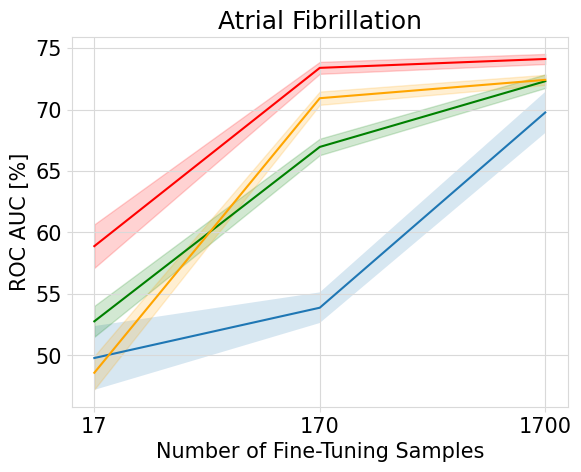

In [26]:
# plt.rcParams.update({'font.size': 15})

x = np.arange(3)
y_vit_af = np.array([vit_af_hundredth.mean(), vit_af_tenth.mean(), vit_af_full.mean()])
y_mmcl_af = np.array([mmcl_af_hundredth.mean(), mmcl_af_tenth.mean(), mmcl_af_full.mean()])
y_mae_af = np.array([mae_af_hundredth.mean(), mae_af_tenth.mean(), mae_af_full.mean()])
y_ours_af = np.array([ours_af_hundredth.mean(), ours_af_tenth.mean(), ours_af_full.mean()])

fig, ax = plt.subplots()

ax.plot(x, y_vit_af, label='ViT')
ax.fill_between(x, (y_vit_af-ci_vit_af), (y_vit_af+ci_vit_af), alpha=.175)

ax.plot(x, y_mae_af, 'green', label='MDM')
ax.fill_between(x, (y_mae_af-ci_mae_af), (y_mae_af+ci_mae_af), color='green', alpha=.175)

ax.plot(x, y_mmcl_af, 'orange', label='MMCL w/o MDM')
ax.fill_between(x, (y_mmcl_af-ci_mmcl_af), (y_mmcl_af+ci_mmcl_af), color='orange', alpha=.175)

ax.plot(x, y_ours_af, 'red', label='MMCL (ours)')
ax.fill_between(x, (y_ours_af-ci_ours_af), (y_ours_af+ci_ours_af), color='red', alpha=.175)

ax.xaxis.set_ticks(np.arange(3))
ax.xaxis.set_ticklabels(x_af)

ax.grid(axis='x', color='0.85')
ax.grid(axis='y', color='0.85')

ax.tick_params(color='0.85')
for spine in ax.spines.values():
    spine.set_edgecolor('0.85')

# Hide the right and top spines
# ax.spines[['right', 'top']].set_visible(False)

# ax.legend(fontsize="11")

ax.set_title('Atrial Fibrillation')
ax.set_xlabel('Number of Fine-Tuning Samples')
ax.set_ylabel('ROC AUC [%]')

plt.show()

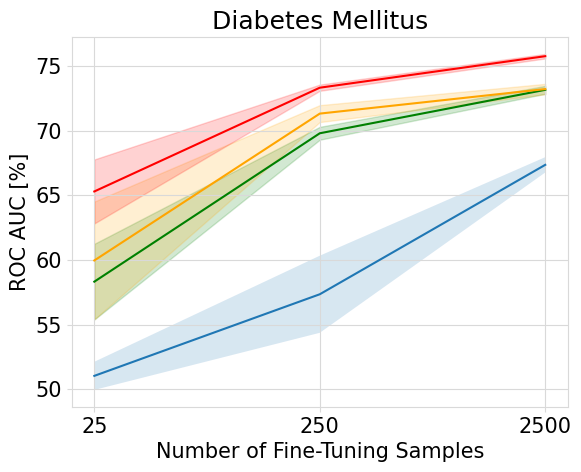

In [27]:
# plt.rcParams.update({'font.size': 15})

x = np.arange(3)
y_vit_dm = np.array([vit_dm_hundredth.mean(), vit_dm_tenth.mean(), vit_dm_full.mean()])
y_mmcl_dm = np.array([mmcl_dm_hundredth.mean(), mmcl_dm_tenth.mean(), mmcl_dm_full.mean()])
y_mae_dm = np.array([mae_dm_hundredth.mean(), mae_dm_tenth.mean(), mae_dm_full.mean()])
y_ours_dm = np.array([ours_dm_hundredth.mean(), ours_dm_tenth.mean(), ours_dm_full.mean()])

fig, ax = plt.subplots()

ax.plot(x, y_vit_dm, label='ViT')
ax.fill_between(x, (y_vit_dm-ci_vit_dm), (y_vit_dm+ci_vit_dm), alpha=.175)

ax.plot(x, y_mae_dm, 'green', label='MDM')
ax.fill_between(x, (y_mae_dm-ci_mae_dm), (y_mae_dm+ci_mae_dm), color='green', alpha=.175)

ax.plot(x, y_mmcl_dm, 'orange', label='MMCL w/o MDM')
ax.fill_between(x, (y_mmcl_dm-ci_mmcl_dm), (y_mmcl_dm+ci_mmcl_dm), color='orange', alpha=.175)

ax.plot(x, y_ours_dm, 'red', label='MMCL (ours)')
ax.fill_between(x, (y_ours_dm-ci_ours_dm), (y_ours_dm+ci_ours_dm), color='red', alpha=.175)

ax.xaxis.set_ticks(np.arange(3))
ax.xaxis.set_ticklabels(x_dm)

ax.grid(axis='x', color='0.85')
ax.grid(axis='y', color='0.85')

ax.tick_params(color='0.85')
for spine in ax.spines.values():
    spine.set_edgecolor('0.85')

# Hide the right and top spines
# ax.spines[['right', 'top']].set_visible(False)

# ax.legend(fontsize="11")

ax.set_title('Diabetes Mellitus')
ax.set_xlabel('Number of Fine-Tuning Samples')
ax.set_ylabel('ROC AUC [%]')

plt.show()

### Other stuff

In [5]:
data_path = "/home/oturgut/sprai/data/preprocessed/ecg"

In [3]:
labels_train = torch.load(os.path.join(data_path, 'labels_train_diabetes_all.pt'))
labels_val = torch.load(os.path.join(data_path, 'labels_val_diabetes_all.pt'))
labels_test = torch.load(os.path.join(data_path, 'labels_test_diabetes_all.pt'))

In [17]:
labels_train = np.array(torch.load(os.path.join(data_path, 'labels_train_flutter_all_balanced.pt')), dtype='int8')
# data_train = torch.load(os.path.join(data_path, 'ecgs_train_diabetes_tenth_balanced_noBase_gn.pt'))

In [18]:
labels_train.shape#, data_train.shape

(1698,)

In [21]:
labels_train_one_hot = torch.nn.functional.one_hot(torch.asarray(labels_train, dtype=torch.int64), num_classes=2)
labels_train_one_hot.shape

torch.Size([24, 2])

In [22]:
# torch.save(labels_train_one_hot, os.path.join(data_path, 'labelsOneHot', 'labels_train_diabetes_hundredth_balanced.pt'))

### Create subset for low data regime

In [5]:
positive_indices = labels_train == 1
positive_indices = positive_indices.nonzero()[0][:int(0.1*0.5*labels_train.shape[0])]

negative_indices = labels_train == 0
negative_indices = negative_indices.nonzero()[0][:int(0.1*0.5*labels_train.shape[0])]

positive_indices.shape, negative_indices.shape

((12,), (12,))

In [6]:
all_indices = np.concatenate((positive_indices, negative_indices), axis=0)
all_indices.shape, all_indices

((24,),
 array([ 0,  1,  3,  7,  8, 14, 17, 19, 20, 21, 22, 23,  2,  4,  5,  6,  9,
        10, 11, 12, 13, 15, 16, 18]))

In [7]:
np.random.shuffle(all_indices)
all_indices

array([20,  9,  0, 11, 23, 21,  4,  1, 15, 14,  3,  2,  6,  7,  8, 16, 10,
       13, 18, 19, 22,  5, 12, 17])

In [8]:
np.unique(labels_train[all_indices], return_counts=True)

(array([0, 1], dtype=int8), array([12, 12]))

In [9]:
labels_train_subset = list(labels_train[all_indices])
data_train_subset = data_train[all_indices]

labels_train[all_indices].shape, data_train_subset.shape

((24,), torch.Size([24, 12, 5000]))

In [10]:
# torch.save(labels_train_subset, os.path.join(data_path, 'labels_train_diabetes_hundredth_balanced.pt'))
# torch.save(data_train_subset, os.path.join(data_path, 'ecgs_train_diabetes_hundredth_balanced_noBase_gn.pt'))

In [2]:
data_path = "/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg"
tab_data_path = "/vol/aimspace/projects/ukbb/668815/basic_features.csv"
cardiac_targets_path = "/vol/aimspace/projects/ukbb/668815/cardiac_features_wenjia_merged.csv"

In [3]:
data = torch.load(os.path.join(data_path, 'ecgsRaw', 'ecgs_val_ecg_imaging.pt'))

In [4]:
len(data), data[0].shape

(6007, torch.Size([12, 5000]))

In [8]:
data_mod = [d.unsqueeze(0) for d in data]

In [11]:
data_mod[0].shape

torch.Size([1, 12, 5000])

### Information about data

In [4]:
idx_train = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/wenjia/missing_indices_train.pt")
idx_val = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/wenjia/missing_indices_val.pt")
idx_test = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/wenjia/missing_indices_test.pt")

print(len(idx_train), len(idx_val), len(idx_test))

14768 3172 3178


In [25]:
# CAD
labels_train = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_train_CAD_all.pt")
labels_val = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_val_CAD_all.pt")
labels_test = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_test_CAD_all.pt")
print(len(labels_train))
print(len(labels_val))
print(len(labels_test))
print(len(labels_train)+len(labels_val)+len(labels_test))

28030
6007
6007
40044


In [16]:
print(np.unique(labels_train, return_counts=True))
print(np.unique(labels_val, return_counts=True))
print(np.unique(labels_test, return_counts=True))

(array([0, 1]), array([26015,  2015]))
(array([0, 1]), array([5574,  433]))
(array([0, 1]), array([5564,  443]))


In [17]:
(2015+443+433) / (5574+5564+26015)

0.07781336634995828

In [20]:
# FLUTTER
labels_train = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_train_flutter_all.pt")
labels_val = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_val_flutter_all.pt")
labels_test = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_test_flutter_all.pt")
print(len(labels_train))
print(len(labels_val))
print(len(labels_test))
print(len(labels_train)+len(labels_val)+len(labels_test))

28030
6007
6007
40044


In [19]:
print(np.unique(labels_train, return_counts=True))
print(np.unique(labels_val, return_counts=True))
print(np.unique(labels_test, return_counts=True))

(array([0, 1]), array([27181,   849]))
(array([0, 1]), array([5839,  168]))
(array([0, 1]), array([5831,  176]))


In [21]:
(849+168+176) / 40044

0.029792228548596544

In [22]:
# DIABETES
labels_train = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_train_diabetes_all.pt")
labels_val = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_val_diabetes_all.pt")
labels_test = torch.load("/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_test_diabetes_all.pt")
print(len(labels_train))
print(len(labels_val))
print(len(labels_test))
print(len(labels_train)+len(labels_val)+len(labels_test))

28030
6007
6007
40044


In [23]:
print(np.unique(labels_train, return_counts=True))
print(np.unique(labels_val, return_counts=True))
print(np.unique(labels_test, return_counts=True))

(array([0, 1]), array([26781,  1249]))
(array([0, 1]), array([5762,  245]))
(array([0, 1]), array([5717,  290]))


In [24]:
(1249+245+290) / 40044

0.04455099390670263

### Extract subset from train, val, test sets

In [3]:
ids_source_name = "ids_val_ecg_imaging.pt"
ids_source = torch.load(os.path.join(data_path, ids_source_name))

In [35]:
ecgs_source_name = "images_val_ecg_imaging.pt"
ecgs_source = torch.load(os.path.join(data_path, ecgs_source_name))

In [36]:
print(len(ecgs_source), ecgs_source[0].shape)

6007 torch.Size([3, 210, 210])


In [53]:
ecgs_source_tensor = torch.cat([img.unsqueeze(dim=0) for img in ecgs_source])
ecgs_source_tensor.shape

torch.Size([6007, 3, 210, 210])

In [54]:
ids_target_name = "ids_val_flutter_all_balanced.pt"
ids_target = torch.load(os.path.join(data_path, ids_target_name))

In [55]:
print(len(ids_source), len(ecgs_source), len(ids_target))

6007 6007 336


In [56]:
target_order = []
for id_t in ids_target:
    for pos, id_s in enumerate(ids_source):
        if id_t == id_s:
            target_order.append(pos)

print(len(target_order))
print(target_order[:10])

336
[2196, 4645, 255, 5756, 1934, 5551, 3241, 2143, 2457, 5358]


In [57]:
ecgs_target_tensor = ecgs_source_tensor[target_order]
print(ecgs_target_tensor.shape)

torch.Size([336, 3, 210, 210])


In [58]:
ecgs_target = [img for img in ecgs_target_tensor]
print(len(ecgs_target), ecgs_target[0].shape)

336 torch.Size([3, 210, 210])


In [59]:
# torch.save(ecgs_target, os.path.join(data_path, "images_val_flutter_all_balanced.pt"))

### Create one hot encoded labels

In [89]:
filename = "labels_train_diabetes_all_balanced.pt"
labels = torch.load(os.path.join(data_path, filename))
print(len(labels))

2498


In [90]:
labels = torch.nn.functional.one_hot(torch.tensor(labels))
print(labels.shape)

In [92]:
torch.unique(labels.argmax(dim=-1), return_counts=True)

(tensor([0, 1]), tensor([1249, 1249]))

In [93]:
# torch.save(labels, os.path.join(data_path, "labelsOneHot", filename))

### Extract 120 cardiac segmentation features from csv

In [4]:
cardiac_targets = pd.read_csv(cardiac_targets_path, sep=',').set_index("eid_87802")
print(cardiac_targets.shape)

cardiac_targets = cardiac_targets.drop(['eid', 'eid_60520', '21003-2.0'], axis=1)
print(cardiac_targets.shape)

(22356, 86)
(22356, 83)


In [3]:
group1 = ['LVEDV (mL)', 'LVESV (mL)', 'LVSV (mL)', 'LVEF (%)', 'LVCO (L/min)', 'LVM (g)']
group2 = ['RVEDV (mL)', 'RVESV (mL)', 'RVSV (mL)', 'RVEF (%)']
group3 = ['LAV max (mL)', 'LAV min (mL)', 'LASV (mL)', 'LAEF (%)']
group4 = ['RAV max (mL)', 'RAV min (mL)', 'RASV (mL)', 'RAEF (%)']
group5 = ['AAo max area (mm2)', 'AAo min area (mm2)', 'AAo distensibility (10-3 mmHg-1)']
group6 = ['DAo max area (mm2)', 'DAo min area (mm2)', 'DAo distensibility (10-3 mmHg-1)']
group7 = ['WT_AHA_1 (mm)', 'WT_AHA_2 (mm)', 'WT_AHA_3 (mm)', 'WT_AHA_4 (mm)', 'WT_AHA_5 (mm)', 'WT_AHA_6 (mm)',
          'WT_AHA_7 (mm)', 'WT_AHA_8 (mm)', 'WT_AHA_9 (mm)', 'WT_AHA_10 (mm)', 'WT_AHA_11 (mm)', 'WT_AHA_12 (mm)', 
          'WT_AHA_13 (mm)', 'WT_AHA_14 (mm)', 'WT_AHA_15 (mm)', 'WT_AHA_16 (mm)', 'WT_Global (mm)']
group8 = ['Ecc_AHA_1 (%)', 'Ecc_AHA_2 (%)', 'Ecc_AHA_3 (%)', 'Ecc_AHA_4 (%)', 'Ecc_AHA_5 (%)', 'Ecc_AHA_6 (%)', 
          'Ecc_AHA_7 (%)', 'Ecc_AHA_8 (%)', 'Ecc_AHA_9 (%)', 'Ecc_AHA_10 (%)', 'Ecc_AHA_11 (%)', 'Ecc_AHA_12 (%)', 
          'Ecc_AHA_13 (%)', 'Ecc_AHA_14 (%)', 'Ecc_AHA_15 (%)', 'Ecc_AHA_16 (%)', 'Ecc_Global (%)']
group9 = ['Err_AHA_1 (%)', 'Err_AHA_2 (%)', 'Err_AHA_3 (%)', 'Err_AHA_4 (%)', 'Err_AHA_5 (%)', 'Err_AHA_6 (%)', 
          'Err_AHA_7 (%)', 'Err_AHA_8 (%)', 'Err_AHA_9 (%)', 'Err_AHA_10 (%)', 'Err_AHA_11 (%)', 'Err_AHA_12 (%)',
          'Err_AHA_13 (%)', 'Err_AHA_14 (%)', 'Err_AHA_15 (%)', 'Err_AHA_16 (%)', 'Err_Global (%)']
group10 = ['Ell_1 (%)', 'Ell_2 (%)', 'Ell_3 (%)', 'Ell_4 (%)', 'Ell_5 (%)', 'Ell_6 (%)', 'Ell_Global (%)']

In [6]:
cardiac_targets.keys()

Index(['LVEDV (mL)', 'LVESV (mL)', 'LVSV (mL)', 'LVEF (%)', 'LVCO (L/min)',
       'LVM (g)', 'RVEDV (mL)', 'RVESV (mL)', 'RVSV (mL)', 'RVEF (%)',
       'LAV max (mL)', 'LAV min (mL)', 'LASV (mL)', 'LAEF (%)', 'RAV max (mL)',
       'RAV min (mL)', 'RASV (mL)', 'RAEF (%)', 'AAo max area (mm2)',
       'AAo min area (mm2)', 'AAo distensibility (10-3 mmHg-1)',
       'DAo max area (mm2)', 'DAo min area (mm2)',
       'DAo distensibility (10-3 mmHg-1)', 'WT_AHA_1 (mm)', 'WT_AHA_2 (mm)',
       'WT_AHA_3 (mm)', 'WT_AHA_4 (mm)', 'WT_AHA_5 (mm)', 'WT_AHA_6 (mm)',
       'WT_AHA_7 (mm)', 'WT_AHA_8 (mm)', 'WT_AHA_9 (mm)', 'WT_AHA_10 (mm)',
       'WT_AHA_11 (mm)', 'WT_AHA_12 (mm)', 'WT_AHA_13 (mm)', 'WT_AHA_14 (mm)',
       'WT_AHA_15 (mm)', 'WT_AHA_16 (mm)', 'WT_Global (mm)', 'Ecc_AHA_1 (%)',
       'Ecc_AHA_2 (%)', 'Ecc_AHA_3 (%)', 'Ecc_AHA_4 (%)', 'Ecc_AHA_5 (%)',
       'Ecc_AHA_6 (%)', 'Ecc_AHA_7 (%)', 'Ecc_AHA_8 (%)', 'Ecc_AHA_9 (%)',
       'Ecc_AHA_10 (%)', 'Ecc_AHA_11 (%)', 'Ecc_AHA_

In [7]:
# load subject ids of train, val, test ecgs
data_ids_train = torch.load(os.path.join(data_path, 'ids_train_ecg_imaging.pt'))
data_ids_val = torch.load(os.path.join(data_path, 'ids_val_ecg_imaging.pt'))
data_ids_test = torch.load(os.path.join(data_path, 'ids_test_ecg_imaging.pt'))

# convert to pandas frame
data_ids_train_pd = pd.DataFrame(data_ids_train, columns=["eid_87802"]).set_index("eid_87802")
data_ids_val_pd = pd.DataFrame(data_ids_val, columns=["eid_87802"]).set_index("eid_87802")
data_ids_test_pd = pd.DataFrame(data_ids_test, columns=["eid_87802"]).set_index("eid_87802")

# print(len(data_ids_train_pd))

In [8]:
# extract corresponding tabular train, val, test data
cardiac_targets_train = data_ids_train_pd.join(cardiac_targets, how="inner")
cardiac_targets_val = data_ids_val_pd.join(cardiac_targets, how="inner")
cardiac_targets_test = data_ids_test_pd.join(cardiac_targets, how="inner")

# print(len(cardiac_targets_train), len(cardiac_targets_val), len(cardiac_targets_test))

In [9]:
missing_indices_train = [idx for idx in data_ids_train_pd.index if idx not in cardiac_targets_train.index]
missing_indices_val = [idx for idx in data_ids_val_pd.index if idx not in cardiac_targets_val.index]
missing_indices_test = [idx for idx in data_ids_test_pd.index if idx not in cardiac_targets_test.index]

# print(len(missing_indices_train), len(missing_indices_val), len(missing_indices_test))

In [14]:
# torch.save(missing_indices_train, os.path.join(data_path, "..", "..", "wenjia", "missing_indices_train.pt"))
# torch.save(missing_indices_val, os.path.join(data_path, "..", "..", "wenjia", "missing_indices_val.pt"))
# torch.save(missing_indices_test, os.path.join(data_path, "..", "..", "wenjia", "missing_indices_test.pt"))

In [15]:
# get the indices of the available subjects (subset) from the dataset (which contains all subjects)
cardiac_targets_train_order = []
for id_t in cardiac_targets_train.index:
    for pos, id_s in enumerate(data_ids_train):
        if id_t == id_s:
            cardiac_targets_train_order.append(pos)

print(len(cardiac_targets_train_order))
print(cardiac_targets_train_order[:10])

cardiac_targets_val_order = []
for id_t in cardiac_targets_val.index:
    for pos, id_s in enumerate(data_ids_val):
        if id_t == id_s:
            cardiac_targets_val_order.append(pos)

print(len(cardiac_targets_val_order))
print(cardiac_targets_val_order[:10])

cardiac_targets_test_order = []
for id_t in cardiac_targets_test.index:
    for pos, id_s in enumerate(data_ids_test):
        if id_t == id_s:
            cardiac_targets_test_order.append(pos)

print(len(cardiac_targets_test_order))
print(cardiac_targets_test_order[:10])

13262
[1, 2, 3, 4, 5, 8, 10, 12, 16, 17]
2835
[2, 4, 5, 6, 17, 18, 21, 23, 24, 26]
2829
[0, 2, 3, 6, 7, 11, 13, 15, 16, 22]


In [10]:
# load train, val, test ecgs
# ecgs_train = torch.load(os.path.join(data_path, 'ecgs_train_ecg_imaging_noBase_gn.pt'))
# ecgs_val = torch.load(os.path.join(data_path, 'ecgs_val_ecg_imaging_noBase_gn.pt'))
# ecgs_test = torch.load(os.path.join(data_path, 'ecgs_test_ecg_imaging_noBase_gn.pt'))

In [8]:
# load train, val, test images
# images_train = torch.load(os.path.join(data_path, 'images_train_ecg_imaging.pt'))
# images_val = torch.load(os.path.join(data_path, 'images_val_ecg_imaging.pt'))
images_test = torch.load(os.path.join(data_path, 'images_test_ecg_imaging.pt'))

In [9]:
len(images_test), images_test[0].shape

(6007, torch.Size([3, 210, 210]))

In [10]:
# images_train_array = torch.cat([i.unsqueeze(dim=0) for i in images_train], dim=0)
# images_val_array = torch.cat([i.unsqueeze(dim=0) for i in images_val], dim=0)
images_test_array = torch.cat([i.unsqueeze(dim=0) for i in images_test], dim=0)

# print(images_test_array.shape)

In [57]:
images_test_2 = [image[0::2, ...] for image in images_test]

In [59]:
len(images_test_2), images_test_2[0].shape

(6007, torch.Size([2, 210, 210]))

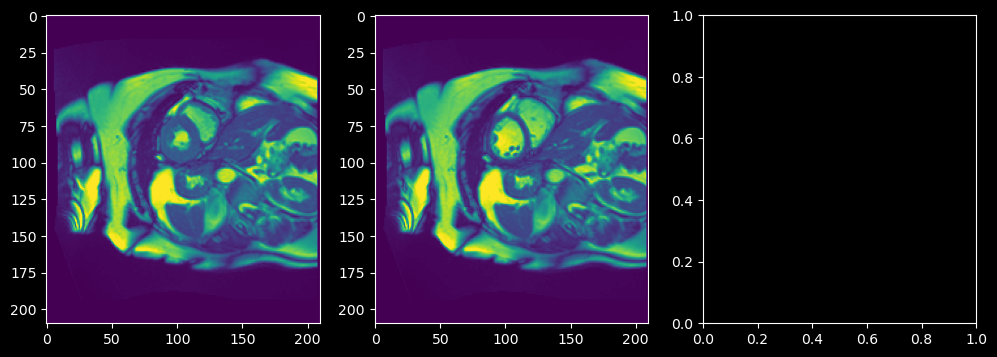

In [60]:
subj = 3000
img_size = 210

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(images_test_2[subj][0].unsqueeze(dim=-1), aspect="auto")
axes[1].imshow(images_test_2[subj][1].unsqueeze(dim=-1), aspect="auto")

plt.show()

In [11]:
images_test_array.shape

torch.Size([6007, 3, 210, 210])

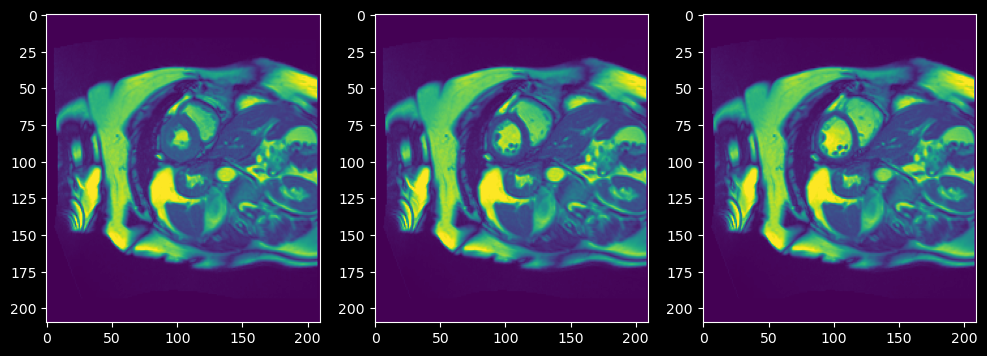

In [33]:
subj = 3000
img_size = 210

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(images_test_array[subj][0].unsqueeze(dim=-1), aspect="auto")
axes[1].imshow(images_test_array[subj][1].unsqueeze(dim=-1), aspect="auto")
axes[2].imshow(images_test_array[subj][2].unsqueeze(dim=-1), aspect="auto")

plt.show()

In [34]:
images_test_array_cropped = torchvision.transforms.functional.crop(images_test_array, top=int(0.21*img_size), left=int(0.325*img_size), height=int(0.375*img_size), width=int(0.375*img_size))

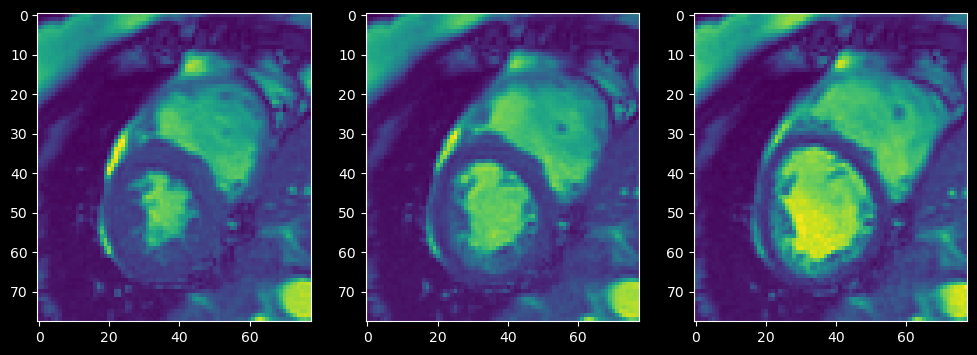

In [56]:
subj = 6000
img_size = 210

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(images_test_array_cropped[subj][0].unsqueeze(dim=-1), aspect="auto")
axes[1].imshow(images_test_array_cropped[subj][1].unsqueeze(dim=-1), aspect="auto")
axes[2].imshow(images_test_array_cropped[subj][2].unsqueeze(dim=-1), aspect="auto")

plt.show()

In [17]:
# select those subjects with available cardiac targets and store them in a separat array
# images_train_regression = images_train_array[cardiac_targets_train_order]
# images_val_regression = images_val_array[cardiac_targets_val_order]
images_test_regression = images_test_array[cardiac_targets_test_order]

# print(images_train_regression.shape)
# print(images_val_regression.shape)
print(images_test_regression.shape)

torch.Size([2829, 3, 210, 210])


In [ ]:
# torch.save(list(images_train_regression), os.path.join(data_path, 'images_train_Regression.pt'))
# torch.save(list(images_val_regression), os.path.join(data_path, 'images_val_Regression.pt'))
# torch.save(list(images_test_regression), os.path.join(data_path, 'images_test_Regression.pt'))

In [ ]:
# select those subjects with available cardiac targets and store them in a separat array
# ecgs_train_regression = ecgs_train[cardiac_targets_train_order]
# ecgs_val_regression = ecgs_val[cardiac_targets_val_order]
ecgs_test_regression = ecgs_test[cardiac_targets_test_order]

# print(ecgs_train_regression.shape)
# print(ecgs_val_regression.shape)
print(ecgs_test_regression.shape)

In [ ]:
# torch.save(ecgs_train_regression, os.path.join(data_path, 'ecgs_train_Regression_noBase_gn.pt'))
# torch.save(ecgs_val_regression, os.path.join(data_path, 'ecgs_val_Regression_noBase_gn.pt'))
# torch.save(ecgs_test_regression, os.path.join(data_path, 'ecgs_test_Regression_noBase_gn.pt'))

In [20]:
# get the ids of those subjects with tabular data
# ids_train_regression = list(cardiac_targets_train.index)
# ids_val_regression = list(cardiac_targets_val.index)
ids_test_regression = list(cardiac_targets_test.index)

# print(len(ids_train_regression))
# print(len(ids_val_regression))
print(len(ids_test_regression))

2829


In [ ]:
# torch.save(ids_train_regression, os.path.join(data_path, 'ids_train_Regression.pt'))
# torch.save(ids_val_regression, os.path.join(data_path, 'ids_val_Regression.pt'))
# torch.save(ids_test_regression, os.path.join(data_path, 'ids_test_Regression.pt'))

In [21]:
cardiac_targets_train.isna().sum(axis=1)

eid_87802
2682030    0
4932301    2
5180420    2
3309089    6
3476191    0
          ..
5823102    0
2582539    0
1054748    0
5940323    0
5835124    0
Length: 13262, dtype: int64

In [22]:
cardiac_targets_train.iloc[1].fillna(0).values

array([141.,  58.,  83.,  59.,   5.,  98., 156.,  61.,  94.,  61.,  82.,
        45.,  37.,  45., 121.,  65.,  56.,  46., 760., 692.,   0., 404.,
       358.,   0.,   8.,   6.,   7.,   7.,   7.,   7.,   6.,   8.,   7.,
         7.,   7.,   7.,   5.,   5.,   5.,   6.,   7., -22., -34., -18.,
       -19., -29., -23., -31., -32., -15., -16., -17., -19., -31., -27.,
       -17., -18., -22.,  70.,  33.,  34.,  51.,  63.,  58.,  48.,  35.,
        40.,  41.,  42.,  46.,  70.,  59.,  52.,  60.,  50., -27., -32.,
       -10., -13., -15., -20., -19.,  64.])

In [ ]:
# # save all tabular values as labels for the 120 parameter regression task
# # note: fill the missing values (i.e. nan) with zeros
# torch.save(cardiac_targets_train.fillna(0).values, os.path.join(data_path, 'labels_train_Regression.pt'))
# torch.save(cardiac_targets_val.fillna(0).values, os.path.join(data_path, 'labels_val_Regression.pt'))
# torch.save(cardiac_targets_test.fillna(0).values, os.path.join(data_path, 'labels_test_Regression.pt'))

In [23]:
~cardiac_targets_train.iloc[1].isna().values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
# # save a mask that shows which values are not nan (required for calculating the loss of the downstream task)
# torch.save(~cardiac_targets_train.isna().values, os.path.join(data_path, 'labels_train_Regression_mask.pt'))
# torch.save(~cardiac_targets_val.isna().values, os.path.join(data_path, 'labels_val_Regression_mask.pt'))
# torch.save(~cardiac_targets_test.isna().values, os.path.join(data_path, 'labels_test_Regression_mask.pt'))

### Tabular classifier & regressor

In [4]:
n_estimators = [50, 75, 100, 125, 150]
max_depth = [3, 4, 5, 6, 7, 8]
lr = [0.1, 0.2, 0.3]
subsample = [0.5, 0.75, 1.0]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=lr, subsample=subsample)

In [5]:
def rmse(target, pred):
    return sklearn.metrics.mean_squared_error(target, pred, squared=False)

def pcc(pred, target):
    return scipy.stats.pearsonr(pred, target)[0]

def roc_auc(estimator, X_test, y_test, pos_label=1):
    y_pred = estimator.predict_proba(X_test)[:, pos_label]
    return sklearn.metrics.roc_auc_score(y_test, y_pred)

In [6]:
tab_data = pd.read_csv(tab_data_path, sep=',').set_index("eid").rename(columns={"21003-2.0":"age", "31-0.0":"sex", "21001-2.0":"bmi", "21002-2.0":"weight", "50-2.0":"height"})

In [7]:
# training data
data_ids_train_cad = torch.load(os.path.join(data_path, 'ids_train_CAD_all_balanced.pt'))
labels_train_cad = torch.load(os.path.join(data_path, f'labels_train_CAD_all_balanced.pt'))

data_ids_train_bmi = torch.load(os.path.join(data_path, 'ids_train_BMI_balanced.pt'))
labels_train_bmi = torch.load(os.path.join(data_path, f'labels_train_BMI_balanced.pt'))

data_ids_train_flutter = torch.load(os.path.join(data_path, 'ids_train_flutter_all_balanced.pt'))
labels_train_flutter = torch.load(os.path.join(data_path, f'labels_train_flutter_all_balanced.pt'))

data_ids_train_diabetes = torch.load(os.path.join(data_path, 'ids_train_diabetes_all_balanced.pt'))
labels_train_diabetes = torch.load(os.path.join(data_path, f'labels_train_diabetes_all_balanced.pt'))

data_ids_train_lvm = torch.load(os.path.join(data_path, 'ids_train_ecg_imaging.pt'))
labels_train_lvm = torch.load(os.path.join(data_path, f'labels_train_LVM_regression.pt'))

# convert to pandas frame
data_ids_train_cad_pd = pd.DataFrame(data_ids_train_cad, columns=["eid"]).set_index("eid")
data_ids_train_bmi_pd = pd.DataFrame(data_ids_train_bmi, columns=["eid"]).set_index("eid")
data_ids_train_flutter_pd = pd.DataFrame(data_ids_train_flutter, columns=["eid"]).set_index("eid")
data_ids_train_diabetes_pd = pd.DataFrame(data_ids_train_diabetes, columns=["eid"]).set_index("eid")
data_ids_train_lvm_pd = pd.DataFrame(data_ids_train_lvm, columns=["eid"]).set_index("eid")

In [8]:
# validation data
data_ids_val_cad = torch.load(os.path.join(data_path, 'ids_val_ecg_imaging.pt'))
labels_val_cad = torch.load(os.path.join(data_path, f'labels_val_CAD_all.pt'))

data_ids_val_bmi = torch.load(os.path.join(data_path, 'ids_val_BMI.pt'))
labels_val_bmi = torch.load(os.path.join(data_path, f'labels_val_BMI.pt'))

data_ids_val_flutter = torch.load(os.path.join(data_path, 'ids_val_ecg_imaging.pt'))
labels_val_flutter = torch.load(os.path.join(data_path, f'labels_val_flutter_all.pt'))

data_ids_val_diabetes = torch.load(os.path.join(data_path, 'ids_val_ecg_imaging.pt'))
labels_val_diabetes = torch.load(os.path.join(data_path, f'labels_val_diabetes_all.pt'))

data_ids_val_lvm = torch.load(os.path.join(data_path, 'ids_val_ecg_imaging.pt'))
labels_val_lvm = torch.load(os.path.join(data_path, f'labels_val_LVM_regression.pt'))

# convert to pandas frame
data_ids_val_cad_pd = pd.DataFrame(data_ids_val_cad, columns=["eid"]).set_index("eid")
data_ids_val_bmi_pd = pd.DataFrame(data_ids_val_bmi, columns=["eid"]).set_index("eid")
data_ids_val_flutter_pd = pd.DataFrame(data_ids_val_flutter, columns=["eid"]).set_index("eid")
data_ids_val_diabetes_pd = pd.DataFrame(data_ids_val_diabetes, columns=["eid"]).set_index("eid")
data_ids_val_lvm_pd = pd.DataFrame(data_ids_val_lvm, columns=["eid"]).set_index("eid")

In [9]:
# test data
data_ids_test_cad = torch.load(os.path.join(data_path, 'ids_test_ecg_imaging.pt'))
labels_test_cad = torch.load(os.path.join(data_path, f'labels_test_CAD_all.pt'))

data_ids_test_bmi = torch.load(os.path.join(data_path, 'ids_test_BMI.pt'))
labels_test_bmi = torch.load(os.path.join(data_path, f'labels_test_BMI.pt'))

data_ids_test_flutter = torch.load(os.path.join(data_path, 'ids_test_ecg_imaging.pt'))
labels_test_flutter = torch.load(os.path.join(data_path, f'labels_test_flutter_all.pt'))

data_ids_test_diabetes = torch.load(os.path.join(data_path, 'ids_test_ecg_imaging.pt'))
labels_test_diabetes = torch.load(os.path.join(data_path, f'labels_test_diabetes_all.pt'))

data_ids_test_lvm = torch.load(os.path.join(data_path, 'ids_test_ecg_imaging.pt'))
labels_test_lvm = torch.load(os.path.join(data_path, f'labels_test_LVM_regression.pt'))

# convert to pandas frame
data_ids_test_cad_pd = pd.DataFrame(data_ids_test_cad, columns=["eid"]).set_index("eid")
data_ids_test_bmi_pd = pd.DataFrame(data_ids_test_bmi, columns=["eid"]).set_index("eid")
data_ids_test_flutter_pd = pd.DataFrame(data_ids_test_flutter, columns=["eid"]).set_index("eid")
data_ids_test_diabetes_pd = pd.DataFrame(data_ids_test_diabetes, columns=["eid"]).set_index("eid")
data_ids_test_lvm_pd = pd.DataFrame(data_ids_test_lvm, columns=["eid"]).set_index("eid")

In [10]:
# get data for the available subjects (subset from wenjia's table)
tab_data_train_cad = data_ids_train_cad_pd.join(tab_data, how="inner")
tab_data_train_bmi = data_ids_train_bmi_pd.join(tab_data, how="inner")
tab_data_train_flutter = data_ids_train_flutter_pd.join(tab_data, how="inner")
tab_data_train_diabetes = data_ids_train_diabetes_pd.join(tab_data, how="inner")
tab_data_train_lvm = data_ids_train_lvm_pd.join(tab_data, how="inner")

tab_data_val_cad = data_ids_val_cad_pd.join(tab_data, how="inner")
tab_data_val_bmi = data_ids_val_bmi_pd.join(tab_data, how="inner")
tab_data_val_flutter = data_ids_val_flutter_pd.join(tab_data, how="inner")
tab_data_val_diabetes = data_ids_val_diabetes_pd.join(tab_data, how="inner")
tab_data_val_lvm = data_ids_val_lvm_pd.join(tab_data, how="inner")

tab_data_test_cad = data_ids_test_cad_pd.join(tab_data, how="inner")
tab_data_test_bmi = data_ids_test_bmi_pd.join(tab_data, how="inner")
tab_data_test_flutter = data_ids_test_flutter_pd.join(tab_data, how="inner")
tab_data_test_diabetes = data_ids_test_diabetes_pd.join(tab_data, how="inner")
tab_data_test_lvm = data_ids_test_lvm_pd.join(tab_data, how="inner")

In [11]:
labels_train_cad = np.array(labels_train_cad, dtype=np.int64)
labels_train_bmi = np.array(labels_train_bmi, dtype=np.int64)
labels_train_flutter = np.array(labels_train_flutter, dtype=np.int64)
labels_train_diabetes = np.array(labels_train_diabetes, dtype=np.int64)
labels_train_lvm = np.array(labels_train_lvm, dtype=np.float64)

labels_val_cad = np.array(labels_val_cad, dtype=np.int64)
labels_val_bmi = np.array(labels_val_bmi, dtype=np.int64)
labels_val_flutter = np.array(labels_val_flutter, dtype=np.int64)
labels_val_diabetes = np.array(labels_val_diabetes, dtype=np.int64)
labels_val_lvm = np.array(labels_val_lvm, dtype=np.float64)

labels_test_cad = np.array(labels_test_cad, dtype=np.int64)
labels_test_bmi = np.array(labels_test_bmi, dtype=np.int64)
labels_test_flutter = np.array(labels_test_flutter, dtype=np.int64)
labels_test_diabetes = np.array(labels_test_diabetes, dtype=np.int64)
labels_test_lvm = np.array(labels_test_lvm, dtype=np.float64)

In [12]:
print(len(data_ids_train_cad), tab_data_train_cad.shape, labels_train_cad.shape)

4030 (4030, 5) (4030,)


In [15]:
# CAD
counts = np.unique(labels_test_cad, return_counts=True)
print(counts)
pos_label = np.argmin(counts[-1])
print(pos_label)

seeds = [0, 101, 202, 303, 404]
results = []

# hyperparameter search
model = xgb.XGBClassifier()
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(tab_data_train_cad[["age", "sex", "weight", "height"]], labels_train_cad)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

for seed in seeds:
    # fit
    classifier = xgb.XGBClassifier(random_state=seed, early_stopping_rounds=50, **grid_result.best_params_)
    classifier.fit(tab_data_train_cad[["age", "sex", "weight", "height"]], labels_train_cad, eval_set=[(tab_data_train_cad[["age", "sex", "weight", "height"]], labels_train_cad), (tab_data_val_cad[["age", "sex", "weight", "height"]], labels_val_cad)], verbose=True)

    # print best scores
    print(classifier.best_iteration, classifier.best_score, classifier.best_ntree_limit)
    print(roc_auc(classifier, tab_data_val_cad[["age", "sex", "weight", "height"]], labels_val_cad, pos_label))

    # evaluate on test data
    result_test = roc_auc(classifier, tab_data_test_cad[["age", "sex", "weight", "height"]], labels_test_cad, pos_label)
    print(result_test)
    results.append(result_test)

result = torch.tensor(results)
print(f"\n Mean: {(result.mean()*100)}, Std: {(result.std()*100)}")

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best: -0.614402 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.75}
[0]	validation_0-logloss:0.67988	validation_1-logloss:0.68046
[1]	validation_0-logloss:0.66863	validation_1-logloss:0.67055
[2]	validation_0-logloss:0.65983	validation_1-logloss:0.66246
[3]	validation_0-logloss:0.65200	validation_1-logloss:0.65624
[4]	validation_0-logloss:0.64567	validation_1-logloss:0.65146
[5]	validation_0-logloss:0.63997	validation_1-logloss:0.64674
[6]	validation_0-logloss:0.63544	validation_1-logloss:0.64352
[7]	validation_0-logloss:0.63124	validation_1-logloss:0.64121
[8]	validation_0-logloss:0.62696	validation_1-logloss:0.63726
[9]	validation_0-logloss:0.62390	validation_1-logloss:0.63432
[10]	validation_0-logloss:0.62109	validation_1-logloss:0.63279
[11]	validation_0-logloss:0.61866	validation_1-logloss:0.63023
[12]	validation_0-logloss:0.61625	validation_1-logloss:0.62921
[13]	validation_0-logloss:0

In [17]:
roc_auc(classifier, tab_data_val_cad, labels_val_cad)

0.6612184498964593

In [13]:
# BMI
model = xgb.XGBClassifier()
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(tab_data_train_diabetes, labels_train_diabetes)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

classifier = xgb.XGBClassifier(eval_metric=sklearn.metrics.roc_auc_score, random_state=seed, early_stopping_rounds=50, **grid_result.best_params_)
classifier.fit(tab_data_train_bmi[["age", "sex", "height"]], labels_train_bmi, eval_set=[(tab_data_val_bmi[["age", "sex", "height"]], labels_val_bmi)], verbose=False)
print(torch.max(torch.tensor(classifier.evals_result()["validation_0"]["roc_auc_score"])))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best: -0.596562 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.75}
tensor(0.7549)


In [20]:
# Flutter
counts = np.unique(labels_test_flutter, return_counts=True)
print(counts)
pos_label = np.argmin(counts[-1])
print(pos_label)

seeds = [0, 101, 202, 303, 404]
results = []

# hyperparameter search
model = xgb.XGBClassifier()
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(tab_data_train_flutter[["age", "sex", "weight", "height"]], labels_train_flutter)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

for seed in seeds:
    # fit
    classifier = xgb.XGBClassifier(random_state=seed, early_stopping_rounds=50, **grid_result.best_params_)
    classifier.fit(tab_data_train_flutter[["age", "sex", "weight", "height"]], labels_train_flutter, eval_set=[(tab_data_train_flutter[["age", "sex", "weight", "height"]], labels_train_flutter), (tab_data_val_flutter[["age", "sex", "weight", "height"]], labels_val_flutter)], verbose=True)

    # print best scores
    print(classifier.best_iteration, classifier.best_score, classifier.best_ntree_limit)
    print(roc_auc(classifier, tab_data_val_flutter[["age", "sex", "weight", "height"]], labels_val_flutter, pos_label))

    # evaluate on test data
    result_test = roc_auc(classifier, tab_data_test_flutter[["age", "sex", "weight", "height"]], labels_test_flutter, pos_label)
    print(result_test)
    results.append(result_test)

result = torch.tensor(results)
print(f"\n Mean: {(result.mean()*100)}, Std: {(result.std()*100)}")

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best: -0.621998 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
[0]	validation_0-logloss:0.67891	validation_1-logloss:0.67965
[1]	validation_0-logloss:0.66701	validation_1-logloss:0.66815
[2]	validation_0-logloss:0.65679	validation_1-logloss:0.65938
[3]	validation_0-logloss:0.64829	validation_1-logloss:0.65122
[4]	validation_0-logloss:0.64085	validation_1-logloss:0.64464
[5]	validation_0-logloss:0.63365	validation_1-logloss:0.63843
[6]	validation_0-logloss:0.62769	validation_1-logloss:0.63341
[7]	validation_0-logloss:0.62239	validation_1-logloss:0.62914
[8]	validation_0-logloss:0.61765	validation_1-logloss:0.62610
[9]	validation_0-logloss:0.61395	validation_1-logloss:0.62316
[10]	validation_0-logloss:0.61038	validation_1-logloss:0.62090
[11]	validation_0-logloss:0.60736	validation_1-logloss:0.61918
[12]	validation_0-logloss:0.60473	validation_1-logloss:0.61727
[13]	validation_0-logloss:0.

In [21]:
# Diabetes
counts = np.unique(labels_test_diabetes, return_counts=True)
print(counts)
pos_label = np.argmin(counts[-1])
print(pos_label)

seeds = [0, 101, 202, 303, 404]
results = []

# hyperparameter search
model = xgb.XGBClassifier()
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(tab_data_train_diabetes[["age", "sex", "weight", "height"]], labels_train_diabetes)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

for seed in seeds:
    # fit
    classifier = xgb.XGBClassifier(random_state=seed, early_stopping_rounds=50, **grid_result.best_params_)
    classifier.fit(tab_data_train_diabetes[["age", "sex", "weight", "height"]], labels_train_diabetes, eval_set=[(tab_data_train_diabetes[["age", "sex", "weight", "height"]], labels_train_diabetes), (tab_data_val_diabetes[["age", "sex", "weight", "height"]], labels_val_diabetes)], verbose=True)

    # print best scores
    print(classifier.best_iteration, classifier.best_score, classifier.best_ntree_limit)
    print(roc_auc(classifier, tab_data_val_diabetes[["age", "sex", "weight", "height"]], labels_val_diabetes, pos_label))

    # evaluate on test data
    result_test = roc_auc(classifier, tab_data_test_diabetes[["age", "sex", "weight", "height"]], labels_test_diabetes, pos_label)
    print(result_test)
    results.append(result_test)

result = torch.tensor(results)
print(f"\n Mean: {(result.mean()*100)}, Std: {(result.std()*100)}")

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best: -0.597514 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.75}
[0]	validation_0-logloss:0.67822	validation_1-logloss:0.67877
[1]	validation_0-logloss:0.66591	validation_1-logloss:0.66878
[2]	validation_0-logloss:0.65593	validation_1-logloss:0.66059
[3]	validation_0-logloss:0.64618	validation_1-logloss:0.65165
[4]	validation_0-logloss:0.63868	validation_1-logloss:0.64651
[5]	validation_0-logloss:0.63141	validation_1-logloss:0.64215
[6]	validation_0-logloss:0.62517	validation_1-logloss:0.63664
[7]	validation_0-logloss:0.61995	validation_1-logloss:0.63404
[8]	validation_0-logloss:0.61598	validation_1-logloss:0.63106
[9]	validation_0-logloss:0.61172	validation_1-logloss:0.62778
[10]	validation_0-logloss:0.60761	validation_1-logloss:0.62598
[11]	validation_0-logloss:0.60407	validation_1-logloss:0.62430
[12]	validation_0-logloss:0.60113	validation_1-logloss:0.62345
[13]	validation_0-logloss:0

In [ ]:
# LVM 
tab_data_train_lvm_noNAN = tab_data_train_lvm.fillna(0.)
tab_data_val_lvm_noNAN = tab_data_val_lvm.fillna(0.)

classifier = xgb.XGBRegressor(random_state=seed, early_stopping_rounds=50)
classifier.fit(tab_data_train_lvm_noNAN[["age", "sex", "weight"]], labels_train_lvm, eval_set=[(tab_data_train_lvm_noNAN[["age", "sex", "weight"]], labels_train_lvm), (tab_data_val_lvm_noNAN[["age", "sex", "weight"]], labels_val_lvm)])

# classifier = sklearn.linear_model.LinearRegression()
# classifier.fit(new_tab_data, labels_train_LVM)

# pred = classifier.predict(new_tab_data_val)
# print(pcc(pred, labels_val_LVM))

To compare the result of the regression task: a random 'model' that predicts the mean only

In [24]:
labels_val_lvm_regr = torch.load(os.path.join(data_path, 'labels_val_LVM_regression.pt'))
labels_val_lvm_regr = np.array(labels_val_lvm_regr)
print(labels_val_lvm_regr.mean())

85.897630746421


In [25]:
rmse_random = (((labels_val_lvm_regr - labels_val_lvm_regr.mean())**2).sum()/len(labels_val_lvm_regr))**0.5
print(rmse_random)

22.101012061587955


#### Multi-output regression cardiac targets

Load data

In [13]:
labels_train_cardiac_regr = torch.load(os.path.join(data_path, 'labelsOneHot/labels_train_Regression_stdNormed.pt'))
labels_train_cardiac_regr_mask = torch.load(os.path.join(data_path, 'labels_train_Regression_mask.pt'))

labels_val_cardiac_regr = torch.load(os.path.join(data_path, 'labelsOneHot/labels_val_Regression_stdNormed.pt'))
labels_val_cardiac_regr_mask = torch.load(os.path.join(data_path, 'labels_val_Regression_mask.pt'))

labels_test_cardiac_regr = torch.load(os.path.join(data_path, 'labelsOneHot/labels_test_Regression_stdNormed.pt'))
labels_test_cardiac_regr_mask = torch.load(os.path.join(data_path, 'labels_test_Regression_mask.pt'))

print(len(labels_train_cardiac_regr), len(labels_val_cardiac_regr), len(labels_test_cardiac_regr))

13262 2835 2829


In [14]:
ids_train_cardiac_regr = torch.load(os.path.join(data_path, "ids_train_Regression.pt"))
ids_val_cardiac_regr = torch.load(os.path.join(data_path, "ids_val_Regression.pt"))
ids_test_cardiac_regr = torch.load(os.path.join(data_path, "ids_test_Regression.pt"))

# convert to pandas frame
ids_train_cardiac_regr_pd = pd.DataFrame(ids_train_cardiac_regr, columns=["eid"]).set_index("eid")
ids_val_cardiac_regr_pd = pd.DataFrame(ids_val_cardiac_regr, columns=["eid"]).set_index("eid")
ids_test_cardiac_regr_pd = pd.DataFrame(ids_test_cardiac_regr, columns=["eid"]).set_index("eid")

In [15]:
# grab all subjects whose ids are available for the regression task
tab_data_train_cardiac_regr = ids_train_cardiac_regr_pd.join(tab_data, how="inner")
tab_data_val_cardiac_regr = ids_val_cardiac_regr_pd.join(tab_data, how="inner")
tab_data_test_cardiac_regr = ids_test_cardiac_regr_pd.join(tab_data, how="inner")

print(tab_data_train_cardiac_regr.shape, labels_train_cardiac_regr.shape, tab_data_val_cardiac_regr.shape, labels_val_cardiac_regr.shape)

(13262, 5) torch.Size([13262, 83]) (2835, 5) torch.Size([2835, 83])


Check data distribution

In [ ]:
# distribution of one cardiac target
labels_array = torch.tensor(labels_train_cardiac_regr)
feature = -1
print(labels_array[..., feature].max(), labels_array[..., feature].min(), labels_array[..., feature].mean(), labels_array[..., feature].median())
plt.hist(labels_array[..., feature].numpy(), bins=200)
plt.show()

In [ ]:
# distribution of all cardiac target
labels_array = torch.tensor(labels_train_cardiac_regr)
features_min, features_max, features_mean, features_median = [], [], [], []
for feature in range(labels_train_cardiac_regr.shape[-1]):
    features_max.append(labels_array[..., feature].max())
    features_min.append(labels_array[..., feature].min())
    features_mean.append(labels_array[..., feature].mean())
    features_median.append(labels_array[..., feature].median())

print(torch.tensor([i.item() for i in features_max], dtype=torch.float))

tensor([ 438.,  276.,  197.,   79.,   15.,  235.,  387.,  215.,  213.,   79.,
         301.,  235.,  170.,   99.,  319.,  273.,  132.,   99., 2750., 2635.,
          25., 1151., 1098.,   24.,   13.,   11.,   11.,   11.,   11.,   12.,
          13.,   15.,   16.,   13.,   11.,   12.,   12.,   11.,   14.,   14.,
          10.,    0.,    0.,    0.,   -0.,    0.,    0.,    0.,    0.,    0.,
           0.,   -0.,    0.,    0.,    0.,    0.,    0.,    0.,   97.,   78.,
          98.,  135.,  145.,  168.,  121.,   95.,  121.,  123.,  130.,  113.,
         103.,  105.,  120.,  116.,   81.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   80.])


/tmp/ipykernel_2638860/3316828065.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_array = torch.tensor(labels_train_cardiac_regr)


Normalize data

In [ ]:
# min max normalize the cardiac features (easier for the model to learn)
labels_train_cardiac_regr_normed = (labels_train_cardiac_regr - labels_train_cardiac_regr.min(axis=0, keepdims=True)[0]) / (labels_train_cardiac_regr.max(axis=0, keepdims=True)[0] - labels_train_cardiac_regr.min(axis=0, keepdims=True)[0])
labels_val_cardiac_regr_normed = (labels_val_cardiac_regr - labels_val_cardiac_regr.min(axis=0, keepdims=True)[0]) / (labels_val_cardiac_regr.max(axis=0, keepdims=True)[0] - labels_val_cardiac_regr.min(axis=0, keepdims=True)[0])
labels_test_cardiac_regr_normed = (labels_test_cardiac_regr - labels_test_cardiac_regr.min(axis=0, keepdims=True)[0]) / (labels_test_cardiac_regr.max(axis=0, keepdims=True)[0] - labels_test_cardiac_regr.min(axis=0, keepdims=True)[0])

In [ ]:
# torch.save(labels_train_cardiac_regr_normed, os.path.join(data_path, "labelsOneHot/labels_train_Regression_normed.pt"))
# torch.save(labels_val_cardiac_regr_normed, os.path.join(data_path, "labelsOneHot/labels_val_Regression_normed.pt"))
# torch.save(labels_test_cardiac_regr_normed, os.path.join(data_path, "labelsOneHot/labels_test_Regression_normed.pt"))

In [ ]:
# standard normalize the cardiac features (easier for the model to learn)
labels_train_cardiac_regr_stdNormed = (labels_train_cardiac_regr - labels_train_cardiac_regr.mean(axis=0, keepdims=True)[0]) / labels_train_cardiac_regr.std(axis=0, keepdims=True)[0]
labels_val_cardiac_regr_stdNormed = (labels_val_cardiac_regr - labels_train_cardiac_regr.mean(axis=0, keepdims=True)[0]) / labels_train_cardiac_regr.std(axis=0, keepdims=True)[0]
labels_test_cardiac_regr_stdNormed = (labels_test_cardiac_regr - labels_train_cardiac_regr.mean(axis=0, keepdims=True)[0]) / labels_train_cardiac_regr.std(axis=0, keepdims=True)[0]

In [ ]:
# torch.save(labels_train_cardiac_regr_stdNormed, os.path.join(data_path, "labelsOneHot/labels_train_Regression_stdNormed.pt"))
# torch.save(labels_val_cardiac_regr_stdNormed, os.path.join(data_path, "labelsOneHot/labels_val_Regression_stdNormed.pt"))
# torch.save(labels_test_cardiac_regr_stdNormed, os.path.join(data_path, "labelsOneHot/labels_test_Regression_stdNormed.pt"))

Summarize cardiac targets in groups

In [17]:
# standard normaliation on ALL sets is applied using mu_trian and sigma_train 
cardiac_targets_train = torch.load(os.path.join(data_path, 'labels_train_Regression.pt'))
cardiac_targets_mean = cardiac_targets_train.mean(dim=0, keepdim=True)
cardiac_targets_std = cardiac_targets_train.std(dim=0, keepdim=True)

In [18]:
# Random performance of the first six cardiac targets
cardiac_targets_test = torch.load(os.path.join(data_path, 'labels_test_Regression.pt'))

print((((cardiac_targets_test[:, 0] - cardiac_targets_mean[0, 0])**2).sum() / 2829)**0.5)
print((((cardiac_targets_test[:, 1] - cardiac_targets_mean[0, 1])**2).sum() / 2829)**0.5)
print((((cardiac_targets_test[:, 2] - cardiac_targets_mean[0, 2])**2).sum() / 2829)**0.5)
print((((cardiac_targets_test[:, 3] - cardiac_targets_mean[0, 3])**2).sum() / 2829)**0.5)
print((((cardiac_targets_test[:, 4] - cardiac_targets_mean[0, 4])**2).sum() / 2829)**0.5)
print((((cardiac_targets_test[:, 5] - cardiac_targets_mean[0, 5])**2).sum() / 2829)**0.5)

tensor(33.3339)
tensor(18.6954)
tensor(19.1074)
tensor(5.9436)
tensor(1.2660)
tensor(21.9188)


In [19]:
group1 = ['LVEDV (mL)', 'LVESV (mL)', 'LVSV (mL)', 'LVEF (%)', 'LVCO (L/min)', 'LVM (g)']
group2 = ['RVEDV (mL)', 'RVESV (mL)', 'RVSV (mL)', 'RVEF (%)']
group3 = ['LAV max (mL)', 'LAV min (mL)', 'LASV (mL)', 'LAEF (%)']
group4 = ['RAV max (mL)', 'RAV min (mL)', 'RASV (mL)', 'RAEF (%)']
group5 = ['AAo max area (mm2)', 'AAo min area (mm2)', 'AAo distensibility (10-3 mmHg-1)']
group6 = ['DAo max area (mm2)', 'DAo min area (mm2)', 'DAo distensibility (10-3 mmHg-1)']
group7 = ['WT_AHA_1 (mm)', 'WT_AHA_2 (mm)', 'WT_AHA_3 (mm)', 'WT_AHA_4 (mm)', 'WT_AHA_5 (mm)', 'WT_AHA_6 (mm)',
          'WT_AHA_7 (mm)', 'WT_AHA_8 (mm)', 'WT_AHA_9 (mm)', 'WT_AHA_10 (mm)', 'WT_AHA_11 (mm)', 'WT_AHA_12 (mm)', 
          'WT_AHA_13 (mm)', 'WT_AHA_14 (mm)', 'WT_AHA_15 (mm)', 'WT_AHA_16 (mm)', 'WT_Global (mm)']
group8 = ['Ecc_AHA_1 (%)', 'Ecc_AHA_2 (%)', 'Ecc_AHA_3 (%)', 'Ecc_AHA_4 (%)', 'Ecc_AHA_5 (%)', 'Ecc_AHA_6 (%)', 
          'Ecc_AHA_7 (%)', 'Ecc_AHA_8 (%)', 'Ecc_AHA_9 (%)', 'Ecc_AHA_10 (%)', 'Ecc_AHA_11 (%)', 'Ecc_AHA_12 (%)', 
          'Ecc_AHA_13 (%)', 'Ecc_AHA_14 (%)', 'Ecc_AHA_15 (%)', 'Ecc_AHA_16 (%)', 'Ecc_Global (%)']
group9 = ['Err_AHA_1 (%)', 'Err_AHA_2 (%)', 'Err_AHA_3 (%)', 'Err_AHA_4 (%)', 'Err_AHA_5 (%)', 'Err_AHA_6 (%)', 
          'Err_AHA_7 (%)', 'Err_AHA_8 (%)', 'Err_AHA_9 (%)', 'Err_AHA_10 (%)', 'Err_AHA_11 (%)', 'Err_AHA_12 (%)',
          'Err_AHA_13 (%)', 'Err_AHA_14 (%)', 'Err_AHA_15 (%)', 'Err_AHA_16 (%)', 'Err_Global (%)']
group10 = ['Ell_1 (%)', 'Ell_2 (%)', 'Ell_3 (%)', 'Ell_4 (%)', 'Ell_5 (%)', 'Ell_6 (%)', 'Ell_Global (%)']

In [20]:
tabular_groups = {0:group1, 1:group2, 2:group3, 3:group4, 4:group5, 5:group6, 6:group7, 7:group8, 8:group9, 9:group10}

In [21]:
def multioutput_pcc(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)

    pcc = 0
    for idx, y_pred_sample in enumerate(y_pred):
        pcc += scipy.stats.pearsonr(y_pred_sample, y_test[idx])[0]

    return pcc / y_test.shape[0]

In [ ]:
# Regression
seeds = [0, 101, 202, 303, 404]

results = []
group_lower_bnd, group_upper_bnd = 0, 0

for idx in range(len(tabular_groups)): 
    group_results = []
    print("Group: ", idx)
    group_upper_bnd += len(tabular_groups[idx])
    print(f"Group lower bnd: {group_lower_bnd}, Group upper bnd: {group_upper_bnd}")

    # hyperparameter search
    model = xgb.XGBRegressor()
    grid_search = GridSearchCV(model, param_grid, scoring="r2", n_jobs=-1, verbose=1)
    grid_result = grid_search.fit(tab_data_train_cardiac_regr, labels_train_cardiac_regr[..., group_lower_bnd:group_upper_bnd])
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    for seed in seeds:
        # fit
        regressor = xgb.XGBRegressor(random_state=seed, early_stopping_rounds=50, **grid_result.best_params_)
        regressor.fit(tab_data_train_cardiac_regr, labels_train_cardiac_regr[..., group_lower_bnd:group_upper_bnd], eval_set=[(tab_data_train_cardiac_regr, labels_train_cardiac_regr[..., group_lower_bnd:group_upper_bnd]), (tab_data_val_cardiac_regr, labels_val_cardiac_regr[..., group_lower_bnd:group_upper_bnd])], verbose=True)

        # print best scores
        print(regressor.best_iteration, regressor.best_score, regressor.best_ntree_limit)
        print(multioutput_pcc(regressor, tab_data_val_cardiac_regr, labels_val_cardiac_regr[..., group_lower_bnd:group_upper_bnd]))

        # evaluate on test data
        result_test = multioutput_pcc(regressor, tab_data_test_cardiac_regr, labels_test_cardiac_regr[..., group_lower_bnd:group_upper_bnd])
        group_results.append(result_test)
        print(result_test)

    group_lower_bnd = group_upper_bnd
    results.append(group_results)

for idx in range(len(tabular_groups)): 
    results = torch.tensor(results)
    print(f"\n Mean: {(results.mean(axis=-1))}, Std: {(results.std(axis=-1))}")

In [22]:
tabular_groups = {0:group1}

In [25]:
# Regression
n_estimators = 50 #[50, 75, 100, 125, 150]
max_depth = 3 #[3, 4, 5, 6, 7, 8]
lr = 0.1 #[0.1, 0.2, 0.3]
subsample = [0.5, 0.75, 1.0]
param_grid = dict(subsample=subsample)

seeds = [0, 101, 202, 303, 404]

group_results = []
group_lower_bnd, group_upper_bnd = 0, 0

for idx in range(len(tabular_groups)): 
    result = []
    lvedv_results = []
    lvesv_results = []
    lvsv_results = []
    lvef_results = []
    lvco_results = []
    lvm_results = []
    print("Group: ", idx)
    group_upper_bnd += len(tabular_groups[idx])
    print(f"Group lower bnd: {group_lower_bnd}, Group upper bnd: {group_upper_bnd}")

    # hyperparameter search
    model = xgb.XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1)
    grid_search = GridSearchCV(model, param_grid, scoring="r2", n_jobs=-1, verbose=1)
    grid_result = grid_search.fit(tab_data_train_cardiac_regr[["age", "sex", "weight", "height"]], labels_train_cardiac_regr[..., group_lower_bnd:group_upper_bnd])
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    for seed in seeds:
        # fit
        regressor = xgb.XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=seed, early_stopping_rounds=50, **grid_result.best_params_)
        regressor.fit(tab_data_train_cardiac_regr[["age", "sex", "weight", "height"]], labels_train_cardiac_regr[..., group_lower_bnd:group_upper_bnd], eval_set=[(tab_data_train_cardiac_regr[["age", "sex", "weight", "height"]], labels_train_cardiac_regr[..., group_lower_bnd:group_upper_bnd]), (tab_data_val_cardiac_regr[["age", "sex", "weight", "height"]], labels_val_cardiac_regr[..., group_lower_bnd:group_upper_bnd])], verbose=True)

        # print best scores
        print(regressor.best_iteration, regressor.best_score, regressor.best_ntree_limit)
        # y_pred = regressor.predict(tab_data_val_cardiac_regr)
        # pcc = 0
        # for i in range(group_lower_bnd, group_upper_bnd):
        #     pcc += pcc(y_pred[:, i], labels_val_cardiac_regr[..., i])
        # pcc /= (group_upper_bnd-group_lower_bnd)
        # print(pcc)

        # evaluate on test data
        y_pred = regressor.predict(tab_data_test_cardiac_regr[["age", "sex", "weight", "height"]])
        result_test = 0
        for idx, i in enumerate(range(group_lower_bnd, group_upper_bnd)):
            result_test += scipy.stats.pearsonr(y_pred[:, idx], labels_test_cardiac_regr[..., i])[0] # returns the statistic
        result_test /= (group_upper_bnd-group_lower_bnd)
        # result_test = multioutput_pcc(regressor, tab_data_test_cardiac_regr[["age", "sex", "weight", "height"]], labels_test_cardiac_regr[..., group_lower_bnd:group_upper_bnd])
        result.append(result_test)
        print(result_test)
        
        lvedv_results.append( rmse(y_pred[:, 0], labels_test_cardiac_regr[..., 0]) )
        lvesv_results.append( rmse(y_pred[:, 1], labels_test_cardiac_regr[..., 1]) )
        lvsv_results.append( rmse(y_pred[:, 2], labels_test_cardiac_regr[..., 2]) )
        lvef_results.append( rmse(y_pred[:, 3], labels_test_cardiac_regr[..., 3]) )
        # lvef_results.append(scipy.stats.pearsonr(y_pred[:, 3], labels_test_cardiac_regr[..., 3])[0])
        lvco_results.append( rmse(y_pred[:, 4], labels_test_cardiac_regr[..., 4]) )
        lvm_results.append( rmse(y_pred[:, 5], labels_test_cardiac_regr[..., 5]) )
        # lvm_results.append(scipy.stats.pearsonr(y_pred[:, 5], labels_test_cardiac_regr[..., 5])[0])

    group_lower_bnd = group_upper_bnd
    group_results.append(result)

for idx in range(len(tabular_groups)): 
    group_results = torch.tensor(group_results)
    print(f"\n Mean: {(group_results.mean(axis=-1))}, Std: {(group_results.std(axis=-1))}")

    lvedv_results = torch.tensor(lvedv_results)
    print(f"\n Mean: {(lvedv_results.mean(axis=-1))}, Std: {(lvedv_results.std(axis=-1))}")

    lvesv_results = torch.tensor(lvesv_results)
    print(f"\n Mean: {(lvesv_results.mean(axis=-1))}, Std: {(lvesv_results.std(axis=-1))}")

    lvsv_results = torch.tensor(lvsv_results)
    print(f"\n Mean: {(lvsv_results.mean(axis=-1))}, Std: {(lvsv_results.std(axis=-1))}")

    lvef_results = torch.tensor(lvef_results)
    print(f"\n Mean: {(lvef_results.mean(axis=-1))}, Std: {(lvef_results.std(axis=-1))}")

    lvco_results = torch.tensor(lvco_results)
    print(f"\n Mean: {(lvco_results.mean(axis=-1))}, Std: {(lvco_results.std(axis=-1))}")

    lvm_results = torch.tensor(lvm_results)
    print(f"\n Mean: {(lvm_results.mean(axis=-1))}, Std: {(lvm_results.std(axis=-1))}")

Group:  0
Group lower bnd: 0, Group upper bnd: 6
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.371463 using {'subsample': 0.75}
[0]	validation_0-rmse:1.06620	validation_1-rmse:1.07088
[1]	validation_0-rmse:1.02188	validation_1-rmse:1.02740
[2]	validation_0-rmse:0.98445	validation_1-rmse:0.99053
[3]	validation_0-rmse:0.95277	validation_1-rmse:0.95940
[4]	validation_0-rmse:0.92618	validation_1-rmse:0.93341
[5]	validation_0-rmse:0.90376	validation_1-rmse:0.91149
[6]	validation_0-rmse:0.88500	validation_1-rmse:0.89318
[7]	validation_0-rmse:0.86913	validation_1-rmse:0.87765
[8]	validation_0-rmse:0.85583	validation_1-rmse:0.86474
[9]	validation_0-rmse:0.84461	validation_1-rmse:0.85393
[10]	validation_0-rmse:0.83534	validation_1-rmse:0.84486
[11]	validation_0-rmse:0.82759	validation_1-rmse:0.83746
[12]	validation_0-rmse:0.82110	validation_1-rmse:0.83110
[13]	validation_0-rmse:0.81571	validation_1-rmse:0.82573
[14]	validation_0-rmse:0.81112	validation_1-rmse:0.82145
[15]	

In [26]:
print(cardiac_targets_std[0, 0] * lvedv_results.mean(), cardiac_targets_std[0, 0] * lvedv_results.std())
print(cardiac_targets_std[0, 1] * lvesv_results.mean(), cardiac_targets_std[0, 1] * lvesv_results.std())
print(cardiac_targets_std[0, 2] * lvsv_results.mean(), cardiac_targets_std[0, 2] * lvsv_results.std())
print(cardiac_targets_std[0, 3] * lvef_results.mean(), cardiac_targets_std[0, 3] * lvef_results.std())
print(cardiac_targets_std[0, 4] * lvco_results.mean(), cardiac_targets_std[0, 4] * lvco_results.std())
print(cardiac_targets_std[0, 5] * lvm_results.mean(), cardiac_targets_std[0, 5] * lvm_results.std())

tensor(24.0246) tensor(0.0176)
tensor(14.4483) tensor(0.0200)
tensor(15.3623) tensor(0.0078)
tensor(5.7050) tensor(0.0046)
tensor(1.0803) tensor(0.0003)
tensor(12.4751) tensor(0.0089)


In [65]:
lvef_tab = cardiac_targets_std[0, 3] * lvef_results

In [ ]:
# ECG Scratch
lvedv = cardiac_targets_std[0, 0] * torch.tensor([ 0.7809, 0.7791, 0.7762, 0.773, 0.7643 ])
print(lvedv.mean(), lvedv.std())

lvesv = cardiac_targets_std[0, 1] * torch.tensor([ 0.7914, 0.7786, 0.7749, 0.7678, 0.7667 ])
print(lvesv.mean(), lvesv.std())

lvsv = cardiac_targets_std[0, 2] * torch.tensor([ 0.8468, 0.8441, 0.8415, 0.8399, 0.8343 ])
print(lvsv.mean(), lvsv.std())

lvef_scratch = cardiac_targets_std[0, 3] * torch.tensor([ 0.9142, 0.9086, 0.9075, 0.9067, 0.9026 ])
print(lvef_scratch.mean(), lvef_scratch.std())

lvco = cardiac_targets_std[0, 4] * torch.tensor([ 0.8881, 0.8763, 0.8745, 0.8731, 0.8699 ])
print(lvco.mean(), lvco.std())

lvm = cardiac_targets_std[0, 5] * torch.tensor([ 0.7432, 0.733, 0.7278, 0.724, 0.7234 ])
print(lvm.mean(), lvm.std())

tensor(25.9672) tensor(0.2192)
tensor(14.6708) tensor(0.1888)
tensor(16.1679) tensor(0.0907)
tensor(5.4067) tensor(0.0249)
tensor(1.1401) tensor(0.0091)
tensor(16.1815) tensor(0.1811)


In [ ]:
# ECG MMonly
lvedv = cardiac_targets_std[0, 0] * torch.tensor([ 0.7627, 0.7605, 0.7604, 0.7513, 0.7481 ])
print(lvedv.mean(), lvedv.std())

lvesv = cardiac_targets_std[0, 1] * torch.tensor([ 0.7596, 0.7596, 0.7578, 0.7568, 0.7551 ])
print(lvesv.mean(), lvesv.std())

lvsv = cardiac_targets_std[0, 2] * torch.tensor([ 0.8381, 0.8374, 0.8327, 0.8275, 0.8213 ])
print(lvsv.mean(), lvsv.std())

lvef_mmOnly = cardiac_targets_std[0, 3] * torch.tensor([ 0.9083, 0.908, 0.9033, 0.9022, 0.8999 ])
print(lvef_mmOnly.mean(), lvef_mmOnly.std())

lvco = cardiac_targets_std[0, 4] * torch.tensor([ 0.8719, 0.8716, 0.871, 0.8652, 0.8649 ])
print(lvco.mean(), lvco.std())

lvm = cardiac_targets_std[0, 5] * torch.tensor([ 0.6983, 0.6976, 0.6976, 0.6868, 0.6846 ])
print(lvm.mean(), lvm.std())

tensor(25.3605) tensor(0.2167)
tensor(14.3285) tensor(0.0363)
tensor(15.9773) tensor(0.1358)
tensor(5.3854) tensor(0.0220)
tensor(1.1304) tensor(0.0046)
tensor(15.3550) tensor(0.1484)


In [ ]:
# ECG MAE
lvedv = cardiac_targets_std[0, 0] * torch.tensor([ 0.7488, 0.7238, 0.7184, 0.7159, 0.7157 ])
print(lvedv.mean(), lvedv.std())

lvesv = cardiac_targets_std[0, 1] * torch.tensor([ 0.7221, 0.7209, 0.7162, 0.7162, 0.7116 ])
print(lvesv.mean(), lvesv.std())

lvsv = cardiac_targets_std[0, 2] * torch.tensor([ 0.836, 0.8048, 0.8032, 0.7985, 0.7975 ])
print(lvsv.mean(), lvsv.std())

lvef_mae = cardiac_targets_std[0, 3] * torch.tensor([ 0.8802, 0.874, 0.8725, 0.8708, 0.8665 ])
print(lvef_mae.mean(), lvef_mae.std())

lvco = cardiac_targets_std[0, 4] * torch.tensor([ 0.8569, 0.8543, 0.8527, 0.846, 0.8421 ])
print(lvco.mean(), lvco.std())

lvm = cardiac_targets_std[0, 5] * torch.tensor([ 0.6873, 0.657, 0.6526, 0.6503, 0.6501 ])
print(lvm.mean(), lvm.std())

tensor(24.2852) tensor(0.4679)
tensor(13.5650) tensor(0.0796)
tensor(15.5276) tensor(0.3065)
tensor(5.1976) tensor(0.0298)
tensor(1.1063) tensor(0.0080)
tensor(14.6123) tensor(0.3503)


In [ ]:
# ECG MM
lvedv = cardiac_targets_std[0, 0] * torch.tensor([ 0.7064, 0.706, 0.7039, 0.7034, 0.7028 ])
print(lvedv.mean(), lvedv.std())

lvesv = cardiac_targets_std[0, 1] * torch.tensor([ 0.7027, 0.7001, 0.6994, 0.6986, 0.6954 ])
print(lvesv.mean(), lvesv.std())

lvsv = cardiac_targets_std[0, 2] * torch.tensor([ 0.7981, 0.7971, 0.7945, 0.7942, 0.7911 ])
print(lvsv.mean(), lvsv.std())

lvef_mm = cardiac_targets_std[0, 3] * torch.tensor([ 0.8752, 0.867, 0.8658, 0.8648, 0.8626 ])
print(lvef_mm.mean(), lvef_mm.std())

lvco = cardiac_targets_std[0, 4] * torch.tensor([ 0.851, 0.8482, 0.8478, 0.8459, 0.8459 ])
print(lvco.mean(), lvco.std())

lvm = cardiac_targets_std[0, 5] * torch.tensor([ 0.6297, 0.6285, 0.6274, 0.6267, 0.6253 ])
print(lvm.mean(), lvm.std())

tensor(23.6142) tensor(0.0538)
tensor(13.2216) tensor(0.0499)
tensor(15.2778) tensor(0.0527)
tensor(5.1635) tensor(0.0287)
tensor(1.1029) tensor(0.0027)
tensor(13.9046) tensor(0.0373)


In [ ]:
# CMR
lvedv = cardiac_targets_std[0, 0] * torch.tensor([ 0.6414, 0.5849, 0.4797, 0.4582, 0.4455 ])
print(lvedv.mean(), lvedv.std())

lvesv = cardiac_targets_std[0, 1] * torch.tensor([ 0.6594, 0.6041, 0.4388, 0.4273, 0.4212 ])
print(lvesv.mean(), lvesv.std())

lvsv = cardiac_targets_std[0, 2] * torch.tensor([ 0.6437, 0.621, 0.62, 0.5798, 0.5637 ])
print(lvsv.mean(), lvsv.std())

lvef_cmr = cardiac_targets_std[0, 3] * torch.tensor([ 0.727, 0.6932, 0.6454, 0.6319, 0.6298 ])
print(lvef_cmr.mean(), lvef_cmr.std())

lvco = cardiac_targets_std[0, 4] * torch.tensor([ 0.7704, 0.7492, 0.7477, 0.7047, 0.6882 ])
print(lvco.mean(), lvco.std())

lvm = cardiac_targets_std[0, 5] * torch.tensor([ 0.6157, 0.4912, 0.4845, 0.401, 0.3867 ])
print(lvm.mean(), lvm.std())

tensor(17.4950) tensor(2.8992)
tensor(9.6464) tensor(2.1344)
tensor(11.6388) tensor(0.6314)
tensor(3.9629) tensor(0.2554)
tensor(0.9523) tensor(0.0445)
tensor(10.5432) tensor(2.0253)


(5, 6)
[5.7049894 5.4067135 5.385394  5.1975718 5.1635084 3.9628506]
[0.00407397 0.02226083 0.01965202 0.02662923 0.02566178 0.22842874]


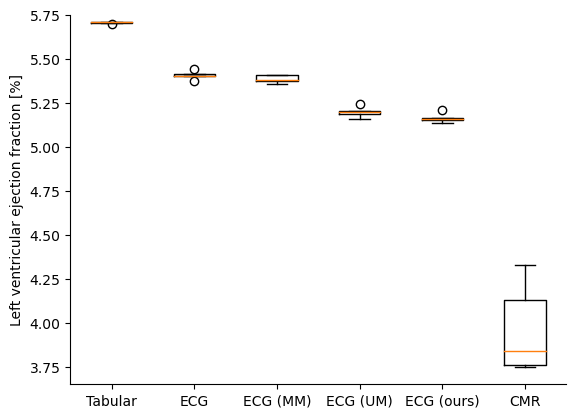

In [73]:
columns = ['Tabular', 'ECG', 'ECG (MM)', 'ECG (UM)', 'ECG (ours)', 'CMR']

aux = np.array(torch.cat((lvef_tab.unsqueeze(1), lvef_scratch.unsqueeze(1), lvef_mmOnly.unsqueeze(1), lvef_mae.unsqueeze(1), lvef_mm.unsqueeze(1), lvef_cmr.unsqueeze(1)), dim=1))
print(aux.shape)

aux_mean = aux.mean(axis=0)
aux_std = aux.std(axis=0)
print(aux_mean)
print(aux_std)

x_pos = np.arange(len(columns))

fig1, ax1 = plt.subplots()
ax1.boxplot(aux)
ax1.set_ylabel('Left ventricular ejection fraction [%]')
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_ylim(top=5.75)
ax1.set_xticks(x_pos+1)
ax1.set_xticklabels(columns)
plt.show()

### Checkout the data

In [3]:
print(data_path)

/home/oturgut/sprai/data/preprocessed/ecg/


In [ ]:
data_ids = torch.load(os.path.join(data_path, 'ecgs_train_ecg_imaging_noBase_gn.pt'))
# print(f"Data shape: {data_ids.shape}")

labels = torch.load(os.path.join(data_path, f'labels_train_LVM_regression.pt'))
# print(f"Labels init shape: {labels.shape}")

print(len(data_ids), len(labels))

28030 28030


In [ ]:
labels[:10]

[72.96431481285094,
 106.75507244052888,
 97.5310701845169,
 79.53767178497314,
 69.25080192203521,
 59.57701017379761,
 86.63198185272216,
 82.4265458404541,
 106.22230460987092,
 84.57259720687867]

tensor(283.6889) tensor(0.) tensor(85.7516) tensor(82.3915)


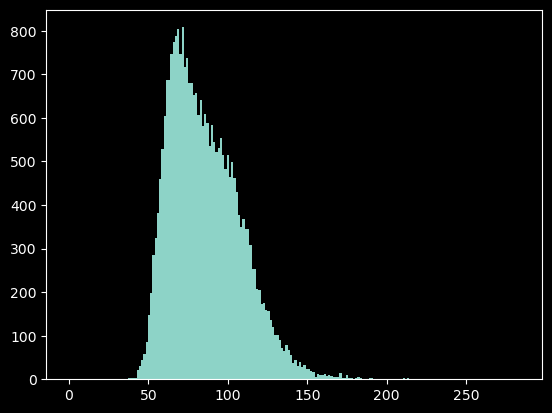

In [ ]:
labels_array = torch.Tensor(labels)
print(labels_array.max(), labels_array.min(), labels_array.mean(), labels_array.median())
plt.hist(labels_array.numpy(), bins=200)
plt.show()

In [ ]:
labels = [label / 300.0 for label in labels] 

tensor(0.6579) tensor(0.1231) tensor(0.2863) tensor(0.2760)


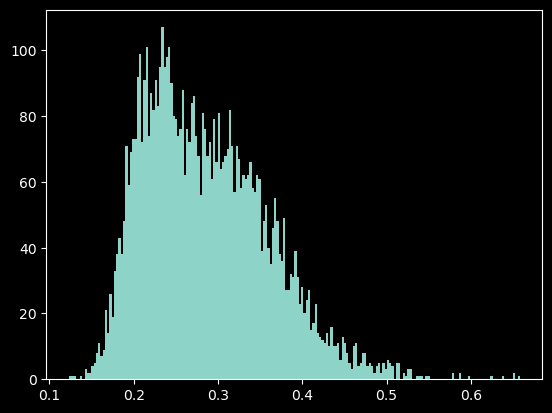

In [ ]:
labels_array = torch.Tensor(labels)
print(labels_array.max(), labels_array.min(), labels_array.mean(), labels_array.median())
plt.hist(labels_array.numpy(), bins=200)
plt.show()

In [ ]:
np.unique(labels.argmax(dim=-1), return_counts=True)

(array([0, 1]), array([5967,   40]))

In [ ]:
print(f"Dataset size:\t{len(data_ids)}")
values, count = np.unique(labels, return_counts=True)
print(f"Label values:\t{values}\nLabel count:\t{count}")

Dataset size:	1050
Label values:	[0. 1.]
Label count:	[1050 1050]


In [ ]:
print(data_ids[:10])
print(labels[:10])

[1002881, 1002897, 1003378, 1004683, 1006320, 1006533, 1007079, 1007295, 1007967, 1009575]
[0, 0, 1, 0, 1, 1, 1, 0, 1, 1]


In [ ]:
data_ids.shape

torch.Size([28030, 12, 5000])

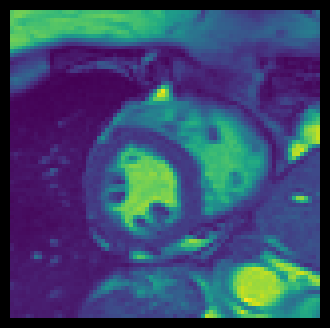

In [27]:
subj = 666
img_size = 210

img = torch.load(os.path.join(data_path, "images_val_CAD_all_balanced.pt"))

img_cropped = [torchvision.transforms.functional.crop(img_single, top=int(0.21*img_size), left=int(0.325*img_size), height=int(0.375*img_size), width=int(0.375*img_size)) for img_single in img]

# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

# axes[0].imshow(img[subj][0].unsqueeze(dim=-1), aspect="auto")
axes.imshow(img_cropped[subj][1].unsqueeze(dim=-1), aspect="auto")
plt.axis('off')

plt.savefig('./1.png', transparent=True)

plt.show()

### Load the data

Single datapoint

In [ ]:
with open('data/3022024_20205_2_0.xml', 'r') as f:
    data = f.read()

bs_data = BeautifulSoup(data, 'xml')

In [ ]:
ecg = torch.Tensor([])

for lead in bs_data.StripData.find_all('WaveformData'):
    lead_torch = torch.Tensor([int(i) for i in "".join(lead.string.split()).split(",")]).unsqueeze(dim=0)
    ecg = torch.cat((ecg, lead_torch), dim=0)

print(ecg.shape)

All data except for the ones with provided ID

In [ ]:
data_path = '/vol/aimspace/projects/ukbb/668815/ecg/'

In [ ]:
def get_all_files(rootdir):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)
        if os.path.isdir(curr_object): 
            files += get_all_files(curr_object)
        elif ".xml" in curr_object:
            files.append(curr_object)

    return files

In [ ]:
files = get_all_files(data_path)
print(len(files))

In [ ]:
ecg_data = torch.Tensor([])

for file in files:
    subj_id = file.split("/")[-1].split("_")[0]

    if int(subj_id) not in data_ids:
        try:
            with open(file, 'r') as f:
                data = f.read()

            bs_data = BeautifulSoup(data, 'xml')

            ecg = torch.Tensor([])
            for lead in bs_data.StripData.find_all('WaveformData'):
                lead_torch = torch.Tensor([int(i) for i in "".join(lead.string.split()).split(",")]).unsqueeze(dim=0)
                ecg = torch.cat((ecg, lead_torch), dim=0)

            ecg_data = torch.cat((ecg_data, ecg.unsqueeze(dim=0)), dim=0)
        except:
            pass

print(ecg_data.shape)

In [ ]:
# torch.save(ecg_data, "/vol/aimspace/oezguen_turgut/sprai/data/preprocessed/ecg/data_pretrain_CAD.pt")

Only data with provided ID

In [ ]:
ecg_path = '/vol/aimspace/projects/ukbb/668815/ecg/'

In [ ]:
ecg_data = torch.Tensor([])
# ecg_labels = []

nonexistent_ids = []

for subj, data_id in enumerate(data_ids):
    try:
        with open(ecg_path+str(data_id)+'_20205_2_0.xml', 'r') as f:
            data = f.read()

        bs_data = BeautifulSoup(data, 'xml')

        ecg = torch.Tensor([])
        for lead in bs_data.StripData.find_all('WaveformData'):
            lead_torch = torch.Tensor([int(i) for i in "".join(lead.string.split()).split(",")]).unsqueeze(dim=0)
            ecg = torch.cat((ecg, lead_torch), dim=0)

        ecg_data = torch.cat((ecg_data, ecg.unsqueeze(dim=0)), dim=0)
        # ecg_labels.append(labels[subj])
    except:
        nonexistent_ids.append(data_id)

print(ecg_data.shape)

torch.Size([4030, 12, 5000])


In [ ]:
len(nonexistent_ids)

0

In [ ]:
# torch.save(ecg_data, os.path.join(data_path, 'ecgs_train_CAD_all_balanced.pt'))
# torch.save(ecg_labels, "/vol/aimspace/oezguen_turgut/sprai/data/preprocessed/ecg/labels_train_CAD.pt")

In [ ]:
# torch.save(nonexistent_ids, os.path.join(data_path, 'nonexistent_ecg_ids_train_CAD_all_balanced.pt'))

### Plot the data

In [43]:
import sys
import torch.fft as fft
from scipy import signal

class ButterworthFiltering(object):
    """ 
        Remove certain frequency bins from the data.
        Butterworth window is used for filtering.
    """
    def __init__(self, fs:int=250, f_0:int=100, band_width:int=5, mode:str="low_pass", order:int=10) -> None:
        super().__init__()
        self.fs = fs
        self.f_0 = f_0
        self.band_width = band_width
        self.mode = mode
        self.order = order

    def __call__(self, sample) -> torch.Tensor:

        if self.mode == "low_pass":
            sos = signal.butter(self.order, self.f_0, 'lowpass', output='sos', fs=self.fs)
        elif self.mode == "high_pass":
            sos = signal.butter(self.order, self.f_0, 'highpass', output='sos', fs=self.fs)
        elif self.mode == "band_stop":
            sos = signal.butter(self.order, [self.f_0-(self.band_width/2), self.f_0+(self.band_width/2)], 'bandstop', output='sos', fs=self.fs)
        elif self.mode == "band_pass":
            sos = signal.butter(self.order, [self.f_0-(self.band_width/2), self.f_0+(self.band_width/2)], 'bandpass', output='sos', fs=self.fs)
        else:
            sys.exit("Error: Mode does not exist.")

        filtered = signal.sosfilt(sos, sample)

        return torch.from_numpy(filtered)

class TimeToFourier(object):
    """
        Go from time domain to frequency domain.
    """
    def __init__(self, factor=1, return_half=False, unsqueeze=False) -> None:
        super().__init__()
        self.factor = factor
        self.return_half = return_half
        self.unsqueeze = unsqueeze

    def __call__(self, sample) -> torch.Tensor:
        sample_dims = sample.dim()

        # define the output length of the Fourier transform
        N = self.factor * sample.shape[-1] 
        
        # perform the Fourier transform and reorder the output to have negative frequencies first
        # note: the output of the Fourier transform is complex (real + imaginary part)
        X_f = 1/N * fft.fftshift(fft.fft(sample, n=N))

        X_f_complex = torch.Tensor()

        if self.unsqueeze == False:
            # # if you want real and imag part to be concatenated 
            # # such that the output has shape [ch*2, time_steps]
            if sample_dims == 2:
                for ch in range(X_f.shape[0]):
                    real_part = torch.real(X_f[ch, :]).unsqueeze(dim=0)
                    imag_part = torch.imag(X_f[ch, :]).unsqueeze(dim=0)

                    # concatenate the real and imaginary parts 
                    complex_pair = torch.cat((real_part, imag_part), dim=0)

                    # concatenate the channels 
                    X_f_complex = torch.cat((X_f_complex, complex_pair), dim=0)
            elif sample_dims == 3:
                    for bin in range(X_f.shape[0]):
                        X_f_bin_complex = torch.Tensor()
                        
                        for ch in range(X_f.shape[1]):
                            real_part = torch.real(X_f[bin, ch, :]).unsqueeze(dim=0)
                            imag_part = torch.imag(X_f[bin, ch, :]).unsqueeze(dim=0)

                            # concatenate the real and imaginary parts 
                            complex_pair = torch.cat((real_part, imag_part), dim=0)#.unsqueeze(dim=0)

                            # concatenate the channels
                            X_f_bin_complex = torch.cat((X_f_bin_complex, complex_pair), dim=0)

                        # concatenate the frequency bins
                        X_f_complex = torch.cat((X_f_complex, X_f_bin_complex.unsqueeze(dim=0)), dim=0)
        else:
            # # if you want real and imag part to be concatenated 
            # # such that the output has shape [2, ch, time_steps]
            X_f_complex = X_f.unsqueeze(dim=-3)
            X_f_real = torch.real(X_f_complex)
            X_f_imag = torch.imag(X_f_complex)

            X_f_complex = torch.cat((X_f_real, X_f_imag), dim=-3)

        # note: the Fourier transform of a signal with only real parts is symmetric 
        #       thus only half of the transform can be returned to save memory
        start_idx = 0
        if self.return_half == True:
            start_idx = int(N/2)
        
        return X_f_complex[..., start_idx:]

In [4]:
ecg_data = torch.load(os.path.join(data_path, "ecgs_val_ecg_imaging_noBase_gn.pt"))
print(ecg_data.shape)

torch.Size([6007, 12, 5000])


In [5]:
subject_nb = 0

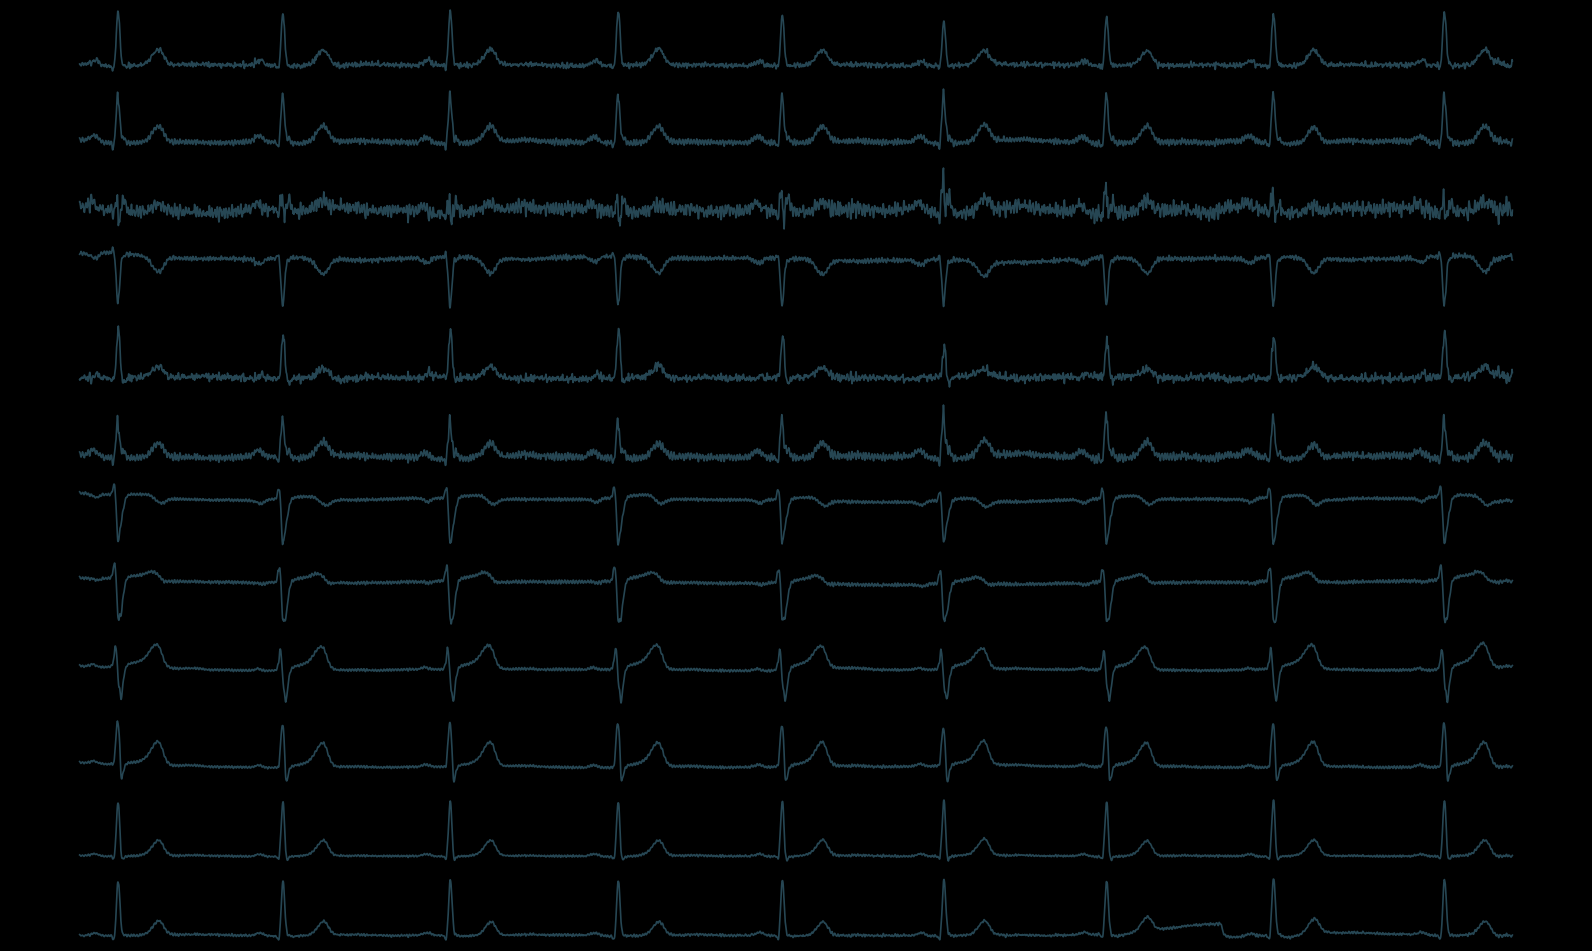

In [6]:
# plots for the paper
data_plot = ecg_data[subject_nb]

step = 1
start = 0
end = 5000
plt.figure(figsize=(20, 12), dpi=80)

plt.subplot(12,1,1)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[0, start:end:step], color='#264653')

plt.subplot(12,1,2)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[1, start:end:step], color="#264653")

plt.subplot(12,1,3)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[2, start:end:step], color="#264653")

plt.subplot(12,1,4)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[3, start:end:step], color="#264653")

plt.subplot(12,1,5)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[4, start:end:step], color="#264653")

plt.subplot(12,1,6)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[5, start:end:step], color="#264653")

plt.subplot(12,1,7)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[6, start:end:step], color="#264653")

plt.subplot(12,1,8)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[7, start:end:step], color="#264653")

plt.subplot(12,1,9)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[8, start:end:step], color="#264653")

plt.subplot(12,1,10)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[9, start:end:step], color="#264653")

plt.subplot(12,1,11)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[10, start:end:step], color="#264653")

plt.subplot(12,1,12)
plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
plt.axis('off')
plt.plot(data_plot[11, start:end:step], color="#264653")

plt.savefig('./demo.png', transparent=True)

plt.tight_layout()
plt.show()

torch.Size([12, 5000])


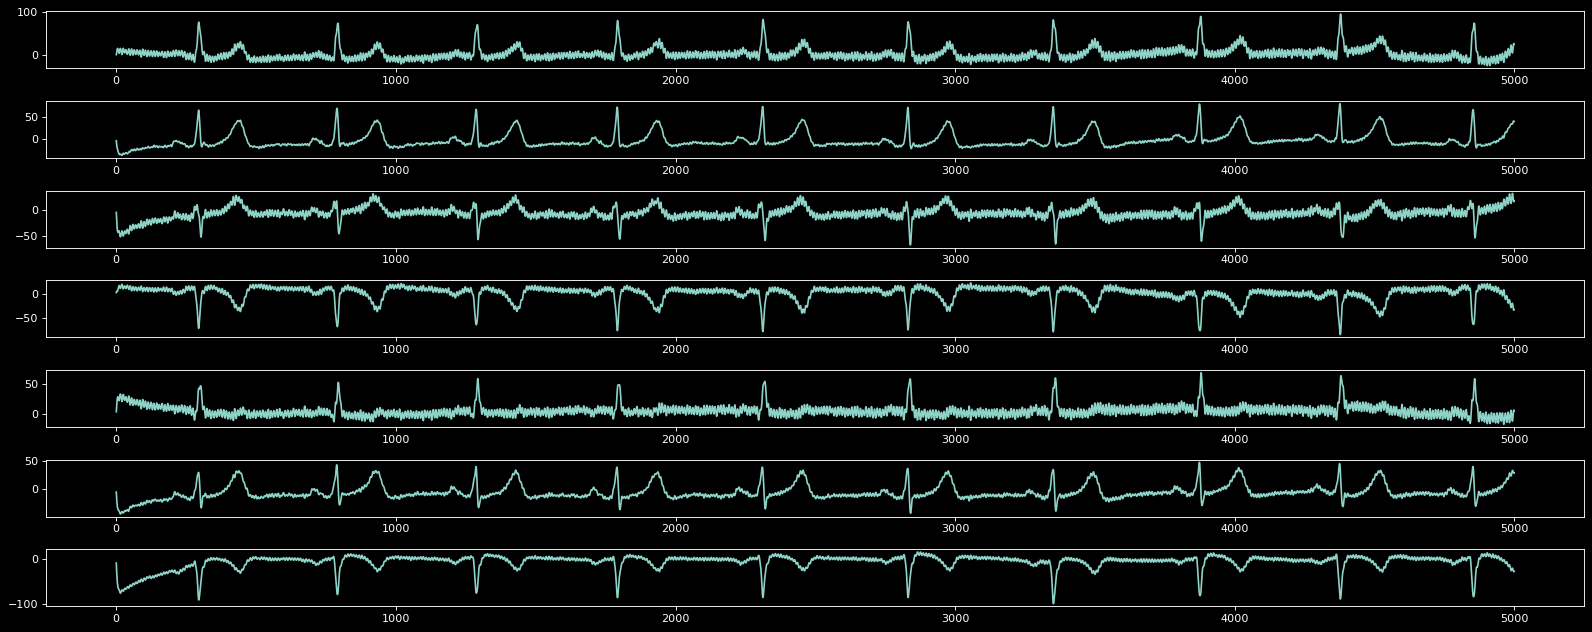

In [85]:
# transform = ButterworthFiltering(fs=500, f_0=0.25, mode="high_pass", order=1)
transform = ButterworthFiltering(fs=500, f_0=10, band_width=19, mode="band_pass", order=1)
data_to_filter = ecg_data[subject_nb]
filtered_data = transform(data_to_filter)

print(filtered_data.shape)

step = 1
plt.figure(figsize=(20, 8), dpi=80)

plt.subplot(711)
plt.plot(filtered_data[0, ::step])

plt.subplot(712)
plt.plot(filtered_data[1, ::step])

plt.subplot(713)
plt.plot(filtered_data[2, ::step])

plt.subplot(714)
plt.plot(filtered_data[3, ::step])

plt.subplot(715)
plt.plot(filtered_data[4, ::step])

plt.subplot(716)
plt.plot(filtered_data[5, ::step])

plt.subplot(717)
plt.plot(filtered_data[6, ::step])

plt.tight_layout()
plt.show()

torch.Size([24, 5000])


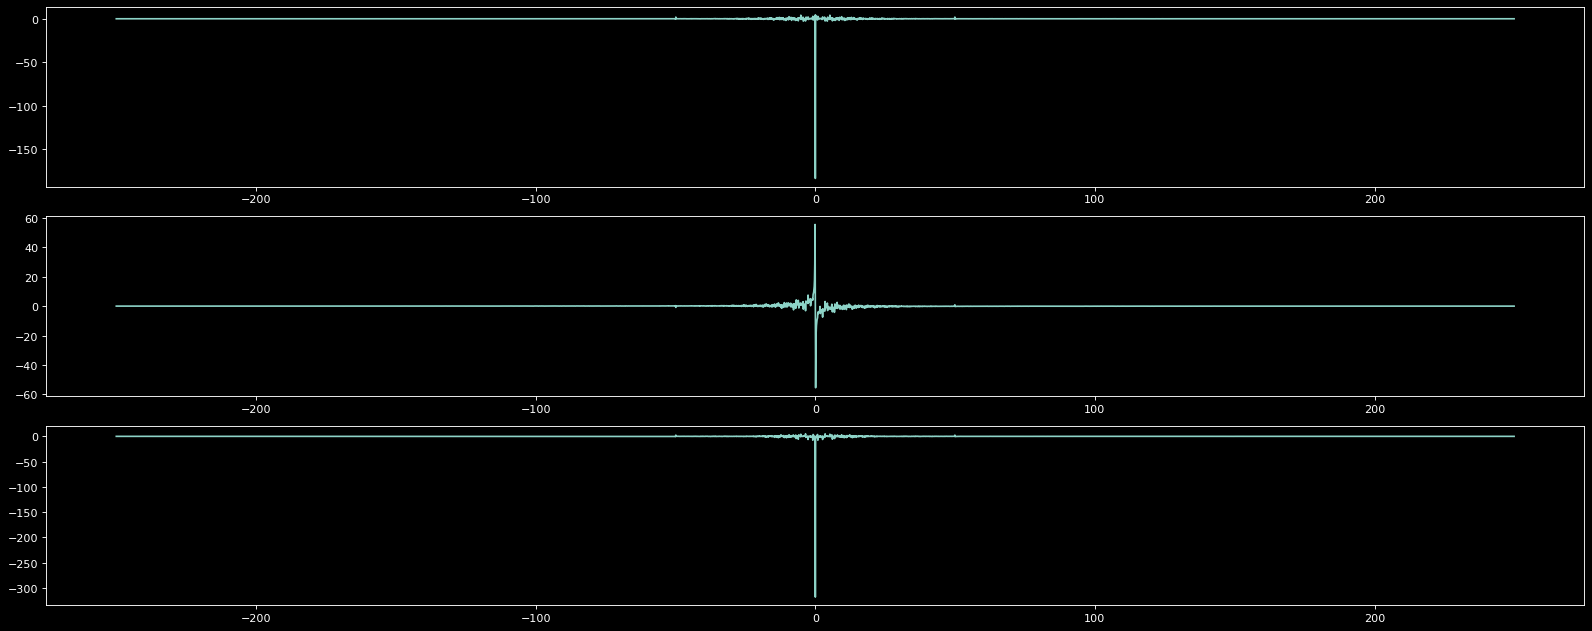

In [55]:
augment = TimeToFourier()
step = 1
data_to_fourier = ecg_data[0, :, ::step]
fourier_data = augment(data_to_fourier)

print(fourier_data.shape)

fs = 500/step
N = data_to_fourier.shape[-1]
f = torch.arange(-N/2, N/2) * 1/N * fs # symmetric + normalized + appyling correct fs

step = 1
plt.figure(figsize=(20, 8), dpi=80)

plt.subplot(311)
plt.plot(f, fourier_data[0, ::step])

plt.subplot(312)
plt.plot(f, fourier_data[1, ::step])

plt.subplot(313)
plt.plot(f, fourier_data[4, ::step])

plt.tight_layout()
plt.show()

In [51]:
# ecg_noBase = torch.load(os.path.join(data_path, "ecgsRaw/noBase/ecgs_val_ecg_imaging_noBase.pt"))
ecg_noBase = torch.load(os.path.join(data_path, "ecgs_val_ecg_imaging_noBase_gn.pt"))
print(ecg_noBase.shape)

torch.Size([6007, 12, 5000])


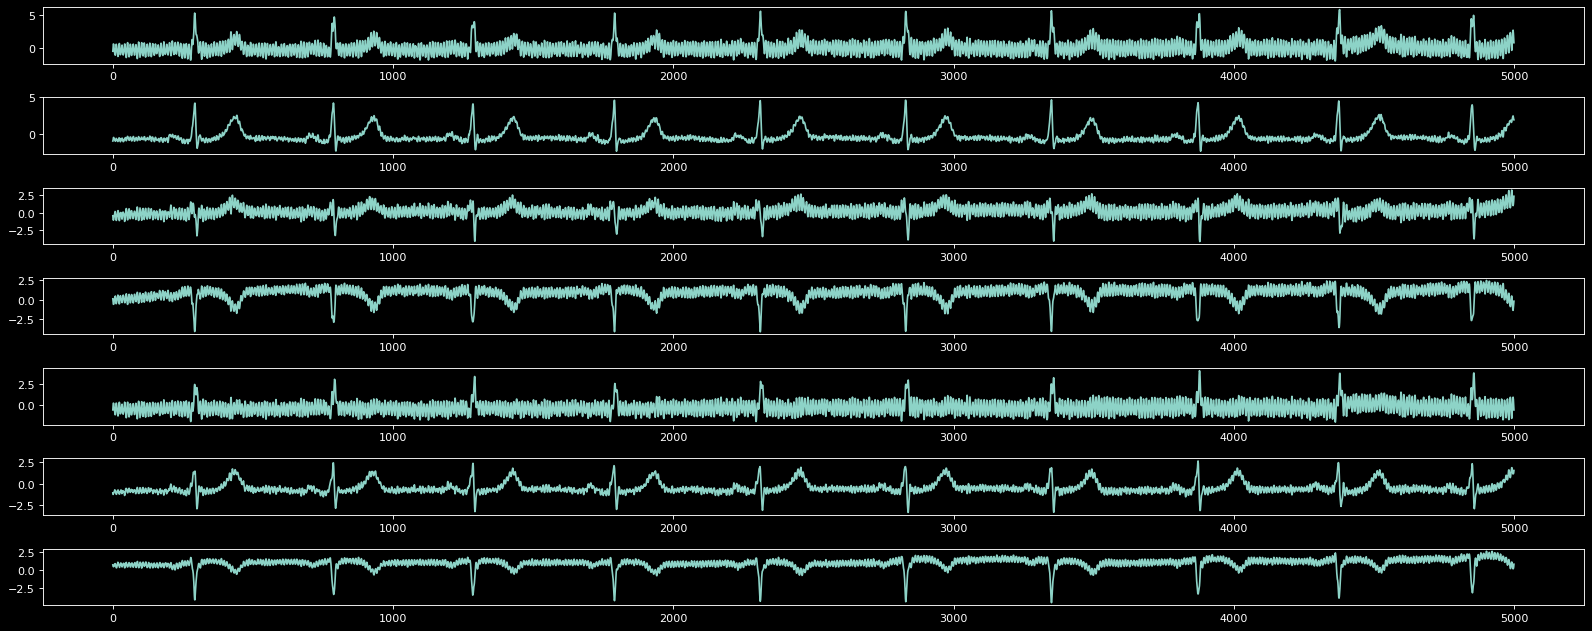

In [80]:
data_plot = ecg_noBase[subject_nb]
step = 1
start = 0
end = 5000
plt.figure(figsize=(20, 8), dpi=80)

plt.subplot(7,1,1)
plt.plot(data_plot[0, start:end:step])

plt.subplot(7,1,2)
plt.plot(data_plot[1, start:end:step])

plt.subplot(7,1,3)
plt.plot(data_plot[2, start:end:step])

plt.subplot(7,1,4)
plt.plot(data_plot[3, start:end:step])

plt.subplot(7,1,5)
plt.plot(data_plot[4, start:end:step])

plt.subplot(7,1,6)
plt.plot(data_plot[5, start:end:step])

plt.subplot(7,1,7)
plt.plot(data_plot[6, start:end:step])

plt.tight_layout()
plt.show()